In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import scipy

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Статистические тесты
### Тест на нормальность Шапиро-Уилка

* Нулевая гипотеза: случайная величина распределена нормально
* Альтернативная гипотеза: случайная величина распределена как угодно, но не нормально.

`p-value` – вероятность, с которой наблюдаемые результаты могли быть получены случайно; или, что тоже самое, вероятность ошибки при отклонении нулевой гипотезы. В случае теста Шапиро-Уилка низкие значения `p-value` свидетельствуют о том, что распределение данных отличается от нормального (нулевая гипотеза ощибочна), высокие – наоборот.

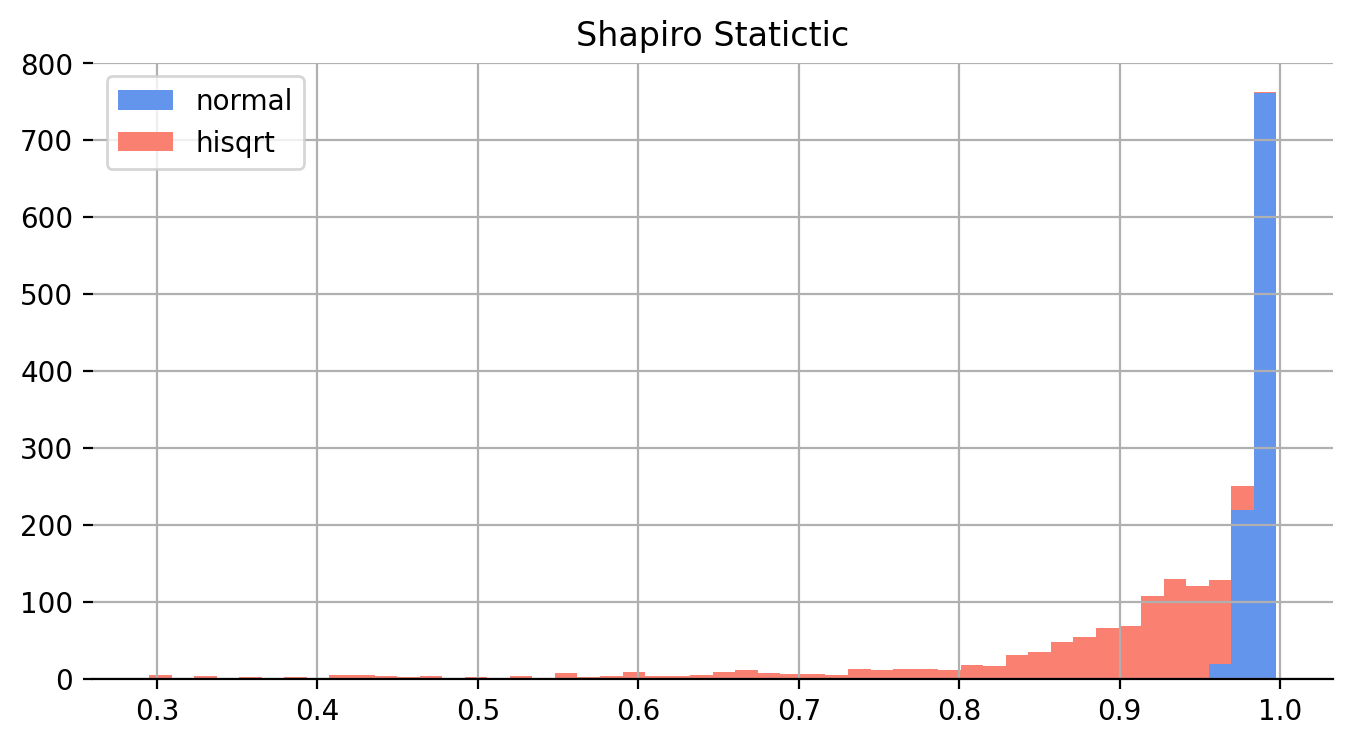

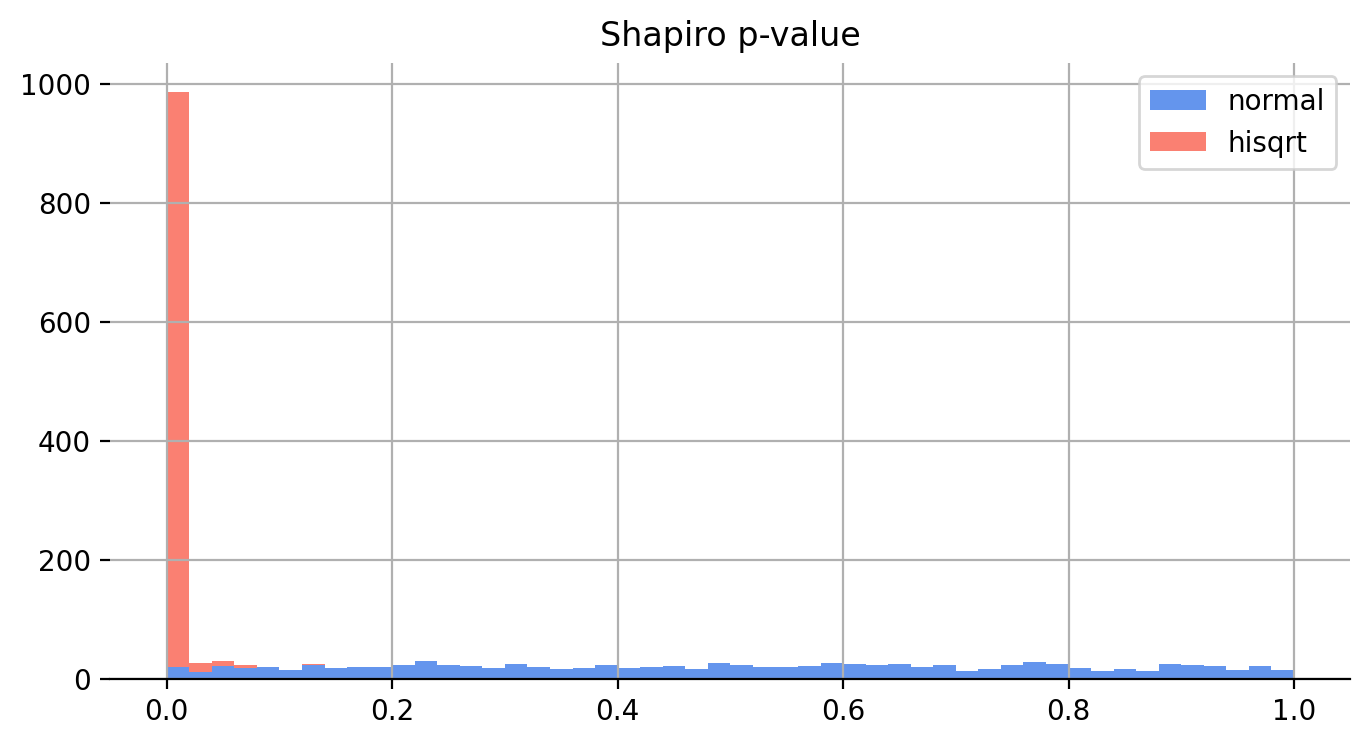

In [9]:
samples = 100
trials = 1000

obs = pd.DataFrame(columns=['stats', 'pvalue', 'dist'])

normal = {'stats': [], 'pvalue': []}
hisqrt = {'stats': [], 'pvalue': []}

for _ in range(trials):

  s1 = np.random.normal(
    loc=np.random.uniform(low=0., high=100.),
    scale=np.random.uniform(low=1., high=10.),
    size=samples
  )

  s2 = np.random.chisquare(
    df=np.random.uniform(low=0.1, high=10.),
    size=100
  )

  r = scipy.stats.shapiro(s1)
  normal['stats'].append(r.statistic) 
  normal['pvalue'].append(r.pvalue)

  r = scipy.stats.shapiro(s2)
  hisqrt['stats'].append(r.statistic) 
  hisqrt['pvalue'].append(r.pvalue)


colors = ['cornflowerblue', 'salmon']
labels = ['normal', 'hisqrt']

plt.figure(figsize=(8, 4))
plt.hist(
  x=[
    normal['stats'], 
    hisqrt['stats']
  ], 
  bins=50, 
  stacked=True, 
  color=colors, 
  label=labels,
)
plt.legend()
plt.title('Shapiro Statictic')
plt.grid(True)
sns.despine(left=True)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(
  x=[
    normal['pvalue'], 
    hisqrt['pvalue']
  ], 
  bins=50, 
  stacked=True, 
  color=colors, 
  label=labels,
)
plt.legend()
plt.title('Shapiro p-value')
plt.grid(True)
sns.despine(left=True)
plt.show()


### t-критерий (Стьюдента)

Параметрический статистический критерий. Нулевая гипотеза: средние равны. Бывает:

* Одновыборочный: сравниваем среднее выборки со средним генеральной совокупности (может быть известна априори);
* Двухвыборочный: сравниваем среднее двух независимых выборок;
* Парный: сравниваем результаты наблюдений за одними и теми же объектами до и после некоторого воздействия; 

 Применяется к данным, для которых справедливо: 

* количество наблюдений – не менее 30;
* оцениваемая случайная величина непрерывна;
* распределение близко к нормальному;
* различие дисперсий в двух группах наблюдений несущественны (гомогенность дисперсий); 

Уазанные допущения должны быть проверены до проведения теста! Нормальность распределения можно, например, проверить с помощью теста [Шапиро-Улка](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%A8%D0%B0%D0%BF%D0%B8%D1%80%D0%BE-%D0%A3%D0%B8%D0%BB%D0%BA%D0%B0), а гомогенность дисперсий – тестом [Левене](https://en.wikipedia.org/wiki/Levene%27s_test), нулевая гипотеза которого формулируется так:

* дисперсии в двух выборках не имеют значимых различий, а это значит, что чем выше `p-value`, тем вероятнее, что это действительно так (нулевую гипотезу нельзя отвергать);

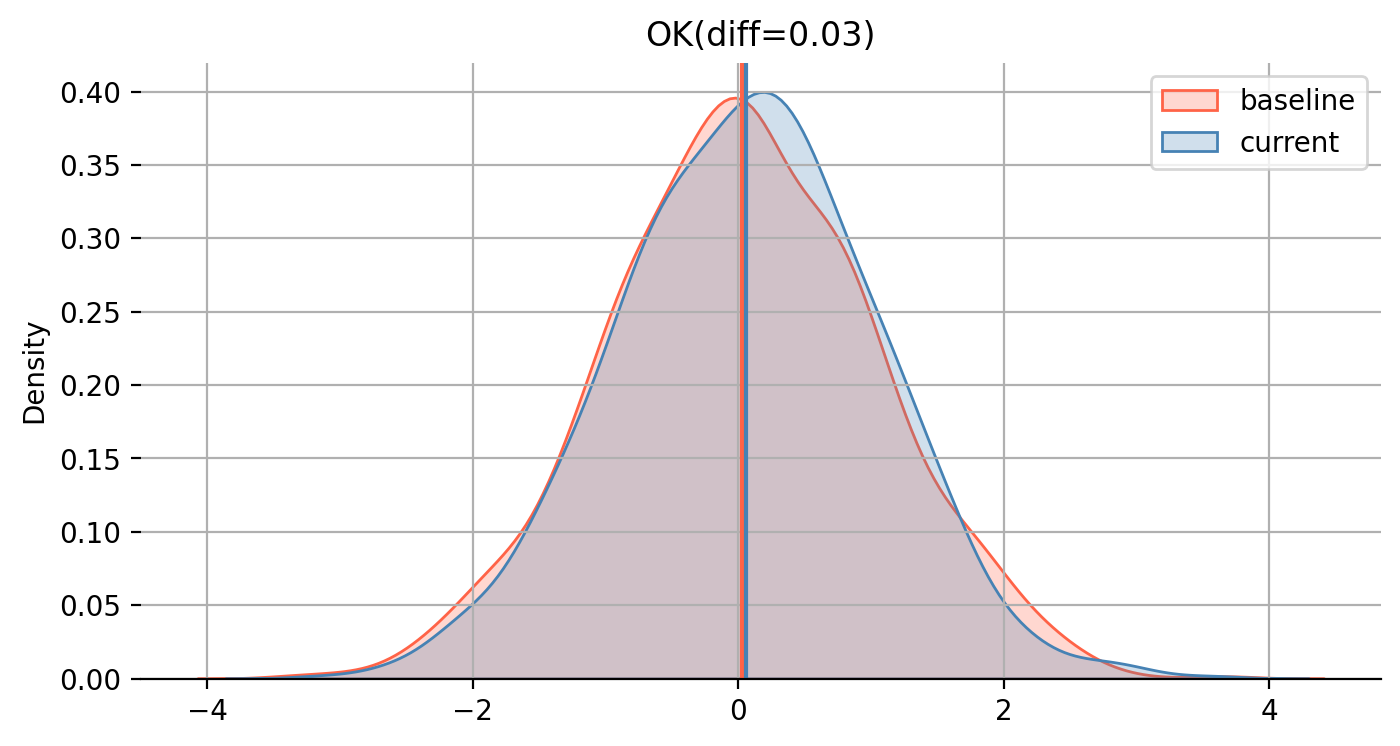

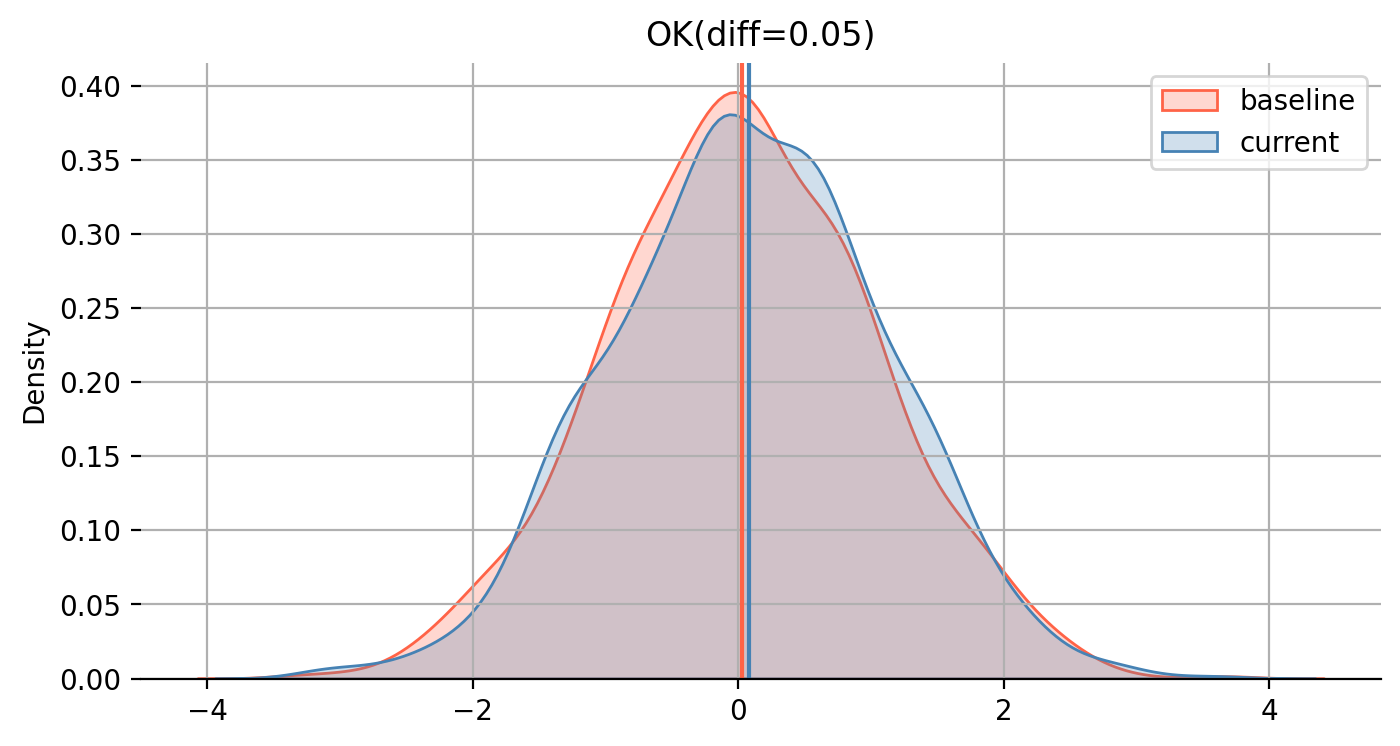

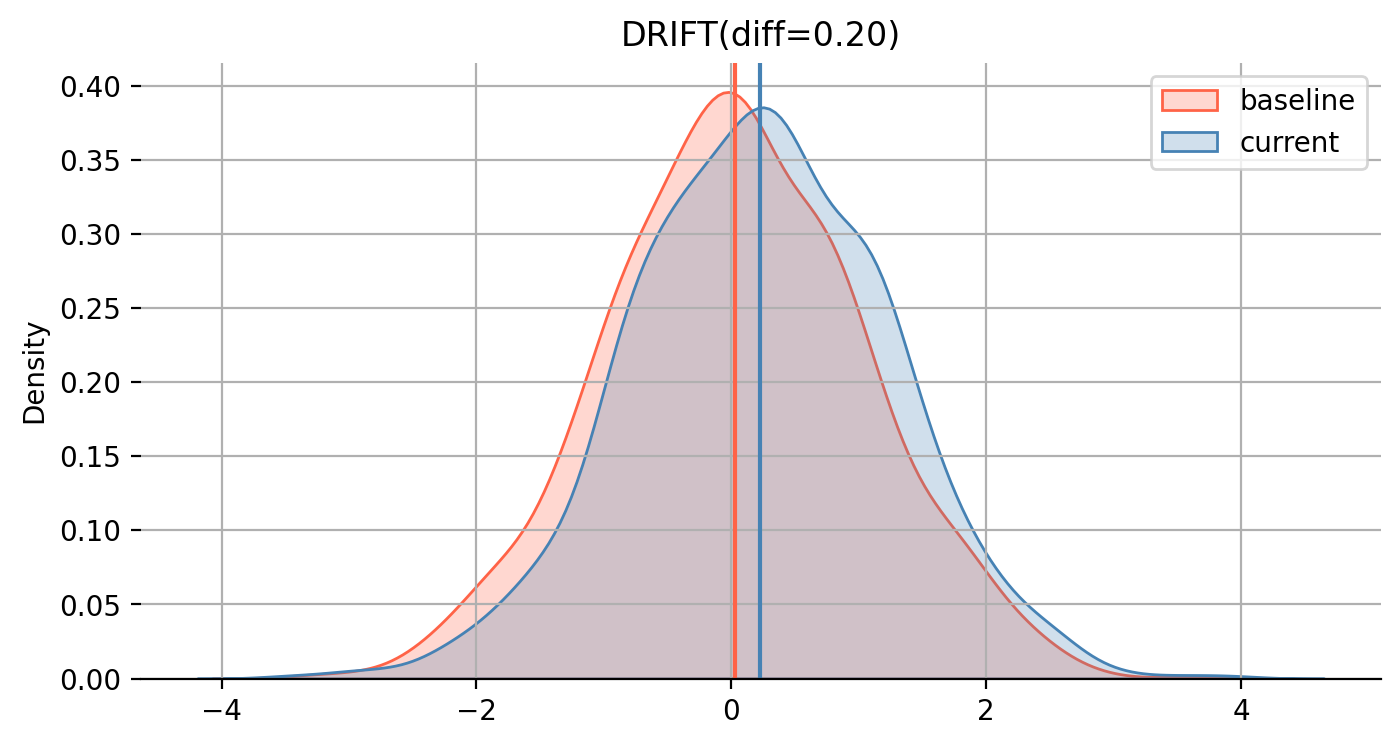

In [14]:
loc = 0
step = 0.05
samples = 1000
bins = samples//10
drift = False
baseline = np.random.normal(loc=loc, size=samples)
baseline_mean = baseline.mean()

custom_palette = ['#FF6347', '#4682B4']

while not drift:
  
  loc +=  step
  current = np.random.normal(loc=loc, size=samples)
  current_mean = current.mean()
  diff_mean = abs(baseline_mean-current_mean)
  
  lt = scipy.stats.levene(baseline, current)

  if lt.pvalue > .05:
    tt = scipy.stats.ttest_ind(baseline, current)
    drift = tt.pvalue < .05 
    
    plt.figure(figsize=(8, 4))
    
    sns.kdeplot(baseline, fill=True, label='baseline', color='#FF6347')
    plt.axvline(x=baseline_mean, color='#FF6347')
    
    sns.kdeplot(current, fill=True, label='current', color='#4682B4')
    plt.axvline(x=current_mean, color='#4682B4')
    
    plt.legend()
    plt.title(('OK' if not drift else 'DRIFT') + f'(diff={diff_mean:.2f})')
    plt.grid(True)
    sns.despine(left=True)
    plt.show()
  else:
    print(f'Trouble with dispersions! Levene:pvalue={lt.pvalue}')

### Критерий Манна-Уитни

Непараметрический тест. Нулевая гипотеза: разница между выборками отсутствует. Не требует, чтобы распределение было нормальным, может работать с малыми выборками. Сравнивает только однородность распределений – такие тесты называю критериами однородности.

In [16]:
loc1 = -1
scale1 = 2

loc2 = -10
scale2 = 20

trials = 100
samples = 6

tt_error = 0
mw_error = 0


for _ in range(trials):
  
  s1 = scipy.stats.uniform(loc=loc1, scale=scale1).rvs(samples) # U[-1, 1]
  s2 = scipy.stats.uniform(loc=loc2, scale=scale2).rvs(samples) # U[-10, 20]

  mw = scipy.stats.mannwhitneyu(s1, s2)
  tt = scipy.stats.ttest_ind(s1, s2)

  # Ошибка первого рода (нулевая гипотеза 
  # принята ошибочно) у Манна-Уитни
  if mw.pvalue < .05:
    mw_error += 1


  # Ошибка первого рода (нулевая гипотеза 
  # принята ошибочно) у Стьюдента
  if tt.pvalue < .05:
    tt_error += 1


left_mw, right_mw = proportion_confint(count=mw_error, nobs=trials, alpha=0.05, method='wilson')
left_tt, right_tt = proportion_confint(count=tt_error, nobs=trials, alpha=0.05, method='wilson')

print(f'Manna-Whitneyu: {mw_error/trials:.2f}, ci95=[{left_mw:.2f}, {right_mw:.2f}]')
print(f'Student: {tt_error/trials:.2f}, ci95=[{left_tt:.2f}, {right_tt:.2f}]')
 

Manna-Whitneyu: 0.04, ci95=[0.02, 0.10]
Student: 0.11, ci95=[0.06, 0.19]


## Критерии однородности

### Критерий однородности Колмогорова-Смирнова

Непараметрический, не требует нормального распределения. Нулевая гипотеза: две выборки получены из одной и той же генеральной совокупности.  

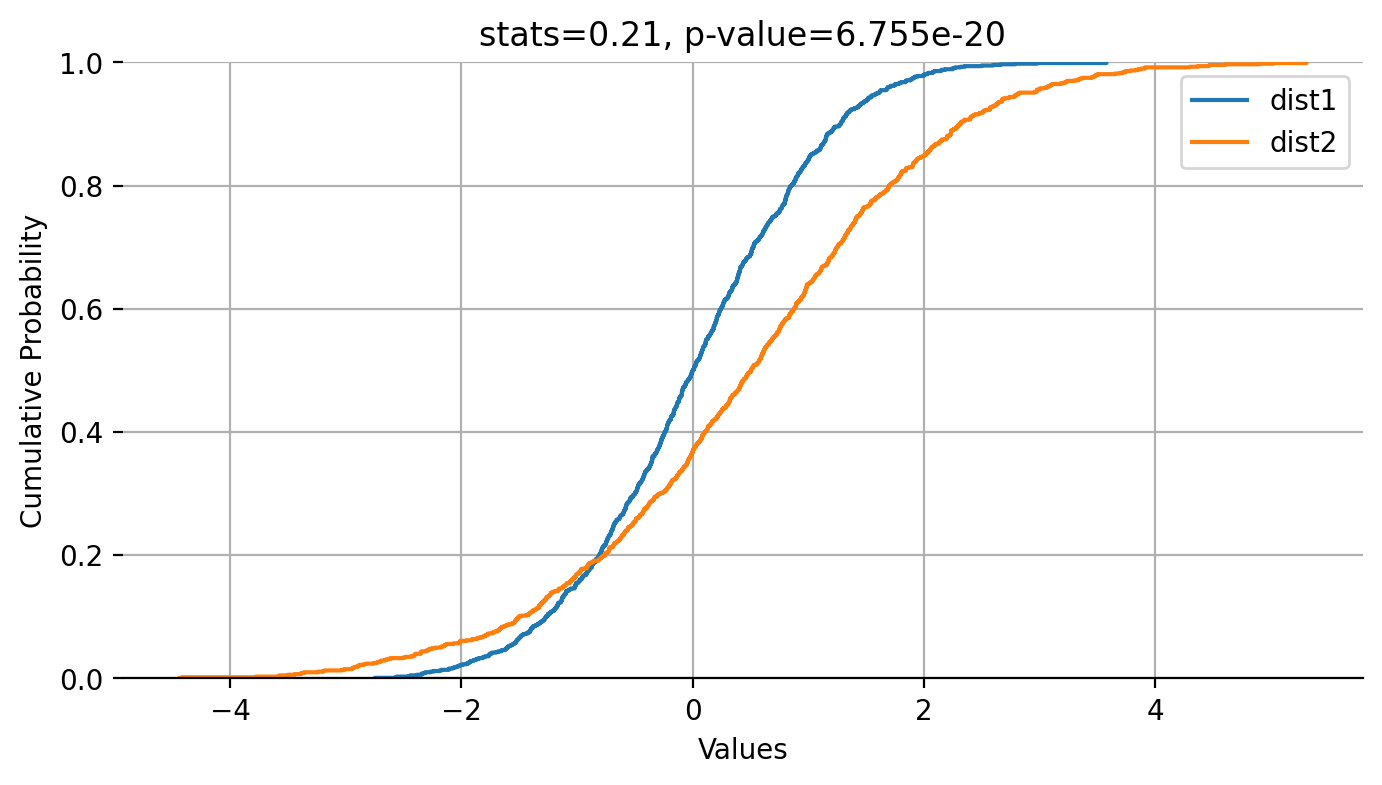

In [19]:
samples = 1000
loc1, scale1 = 0., 1.
loc2, scale2 = 0.5, 1.5

s1 = np.random.normal(loc=loc1, scale=scale1, size=samples)
s2 = np.random.normal(loc=loc2, scale=scale2, size=samples)

r = scipy.stats.ks_2samp(s1, s2)

plt.figure(figsize=(8, 4))
plt.grid(True)
plt.ecdf(s1, label='dist1')
plt.ecdf(s2, label='dist2')
plt.ylabel('Cumulative Probability')
plt.xlabel('Values')
plt.title(f'stats={r.statistic:.2}, p-value={r.pvalue:.4}')
sns.despine(left=True)
plt.legend()

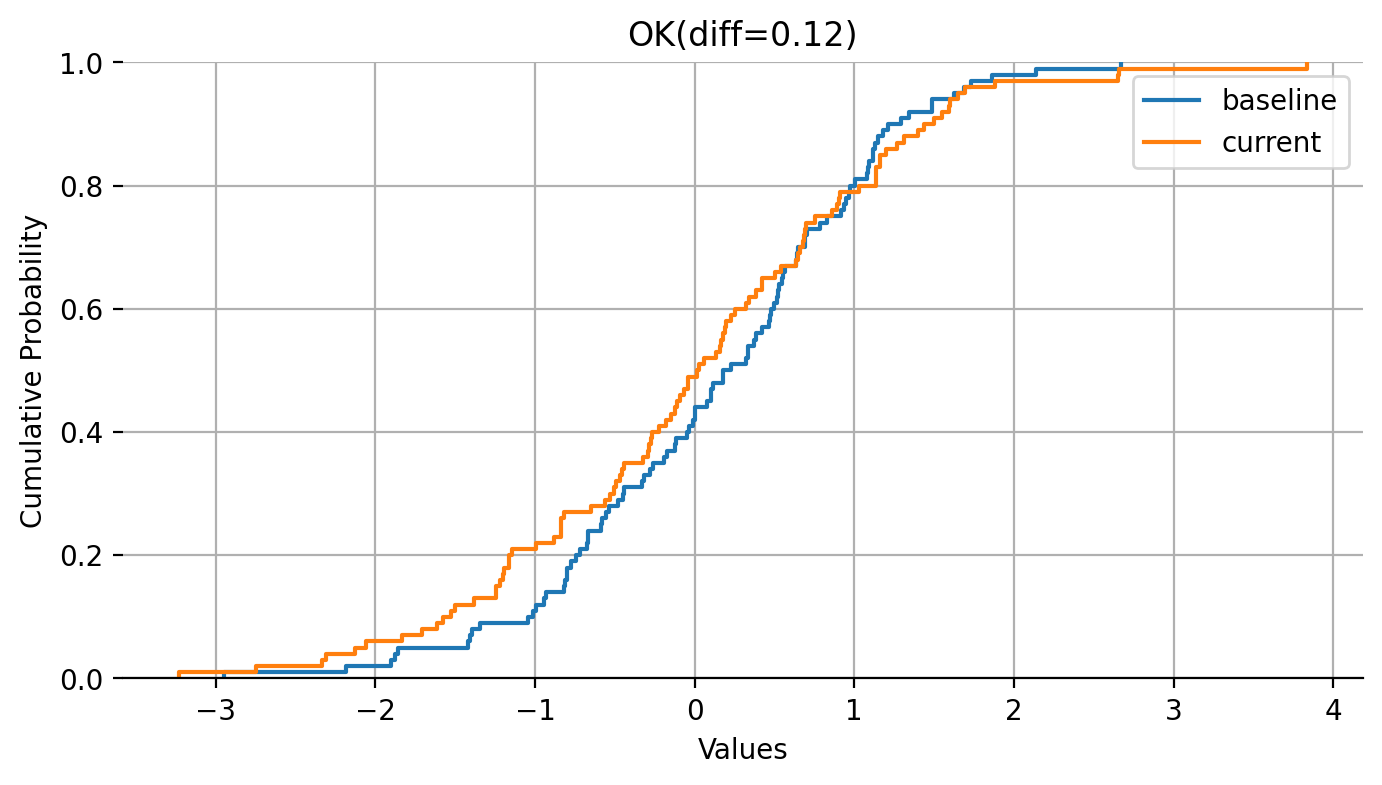

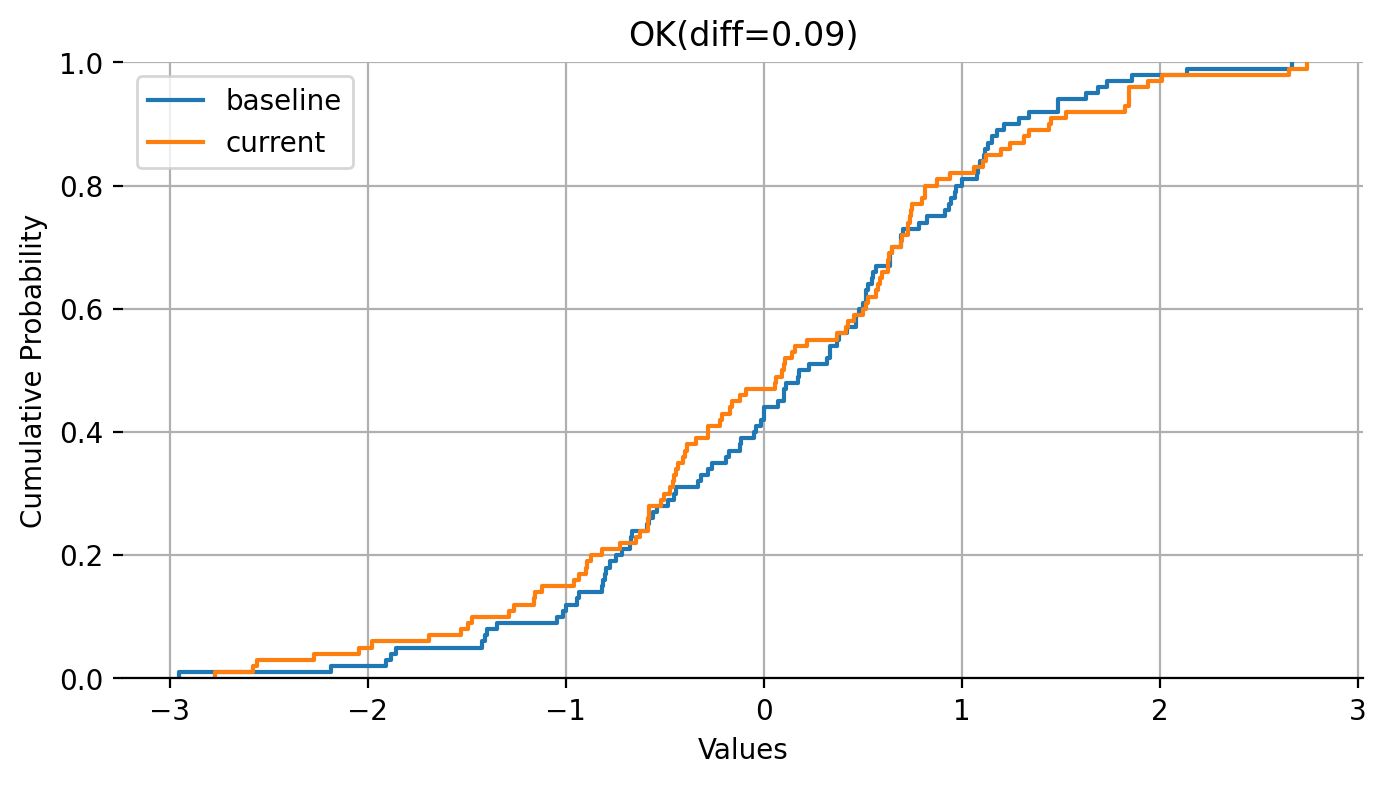

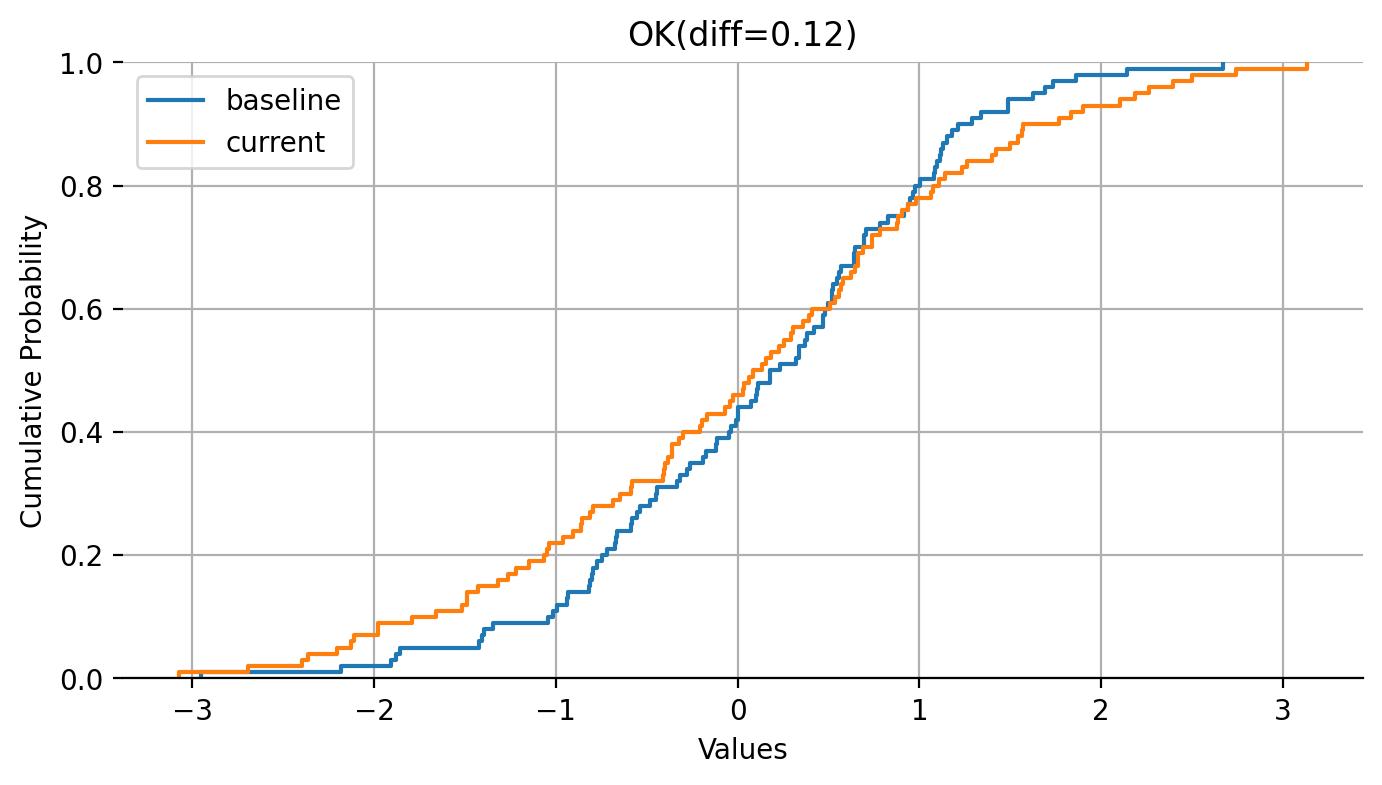

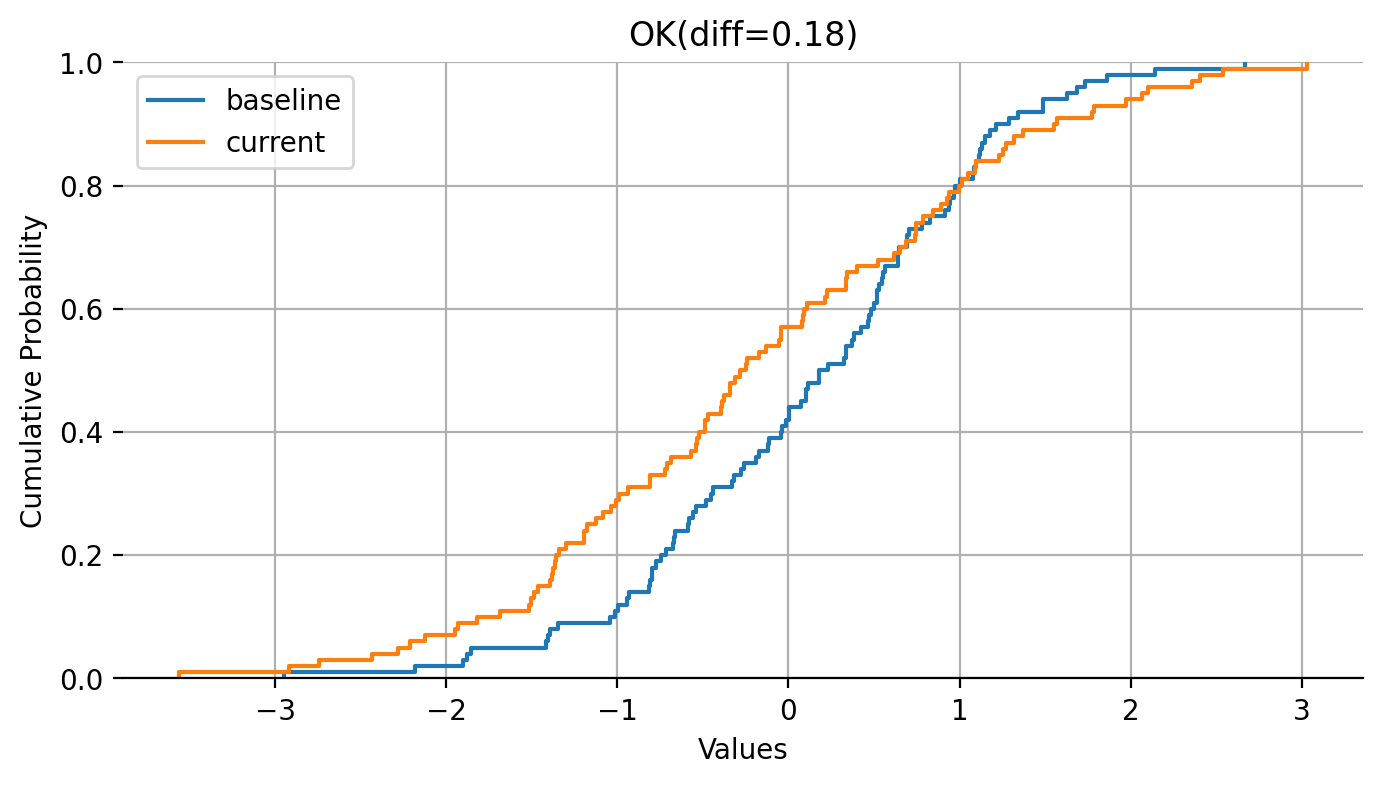

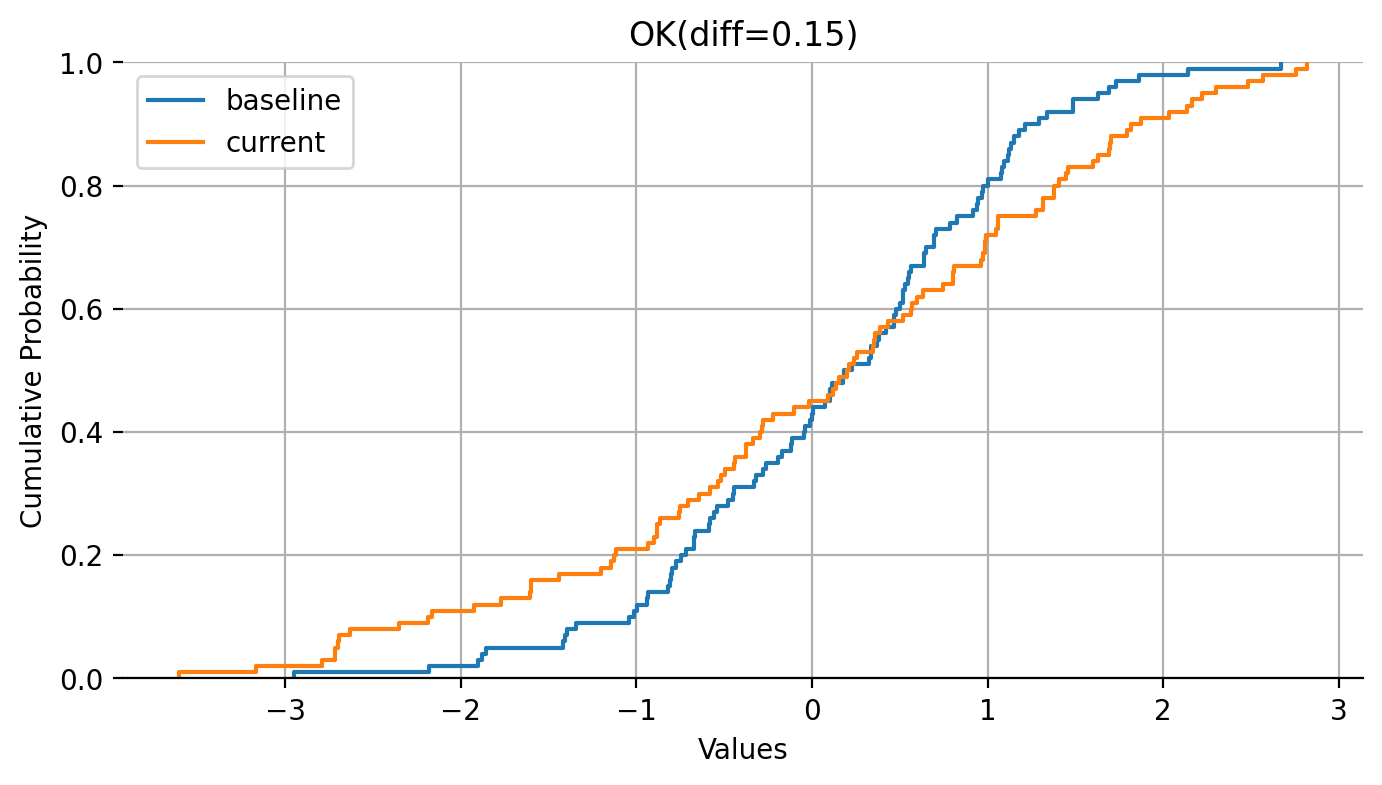

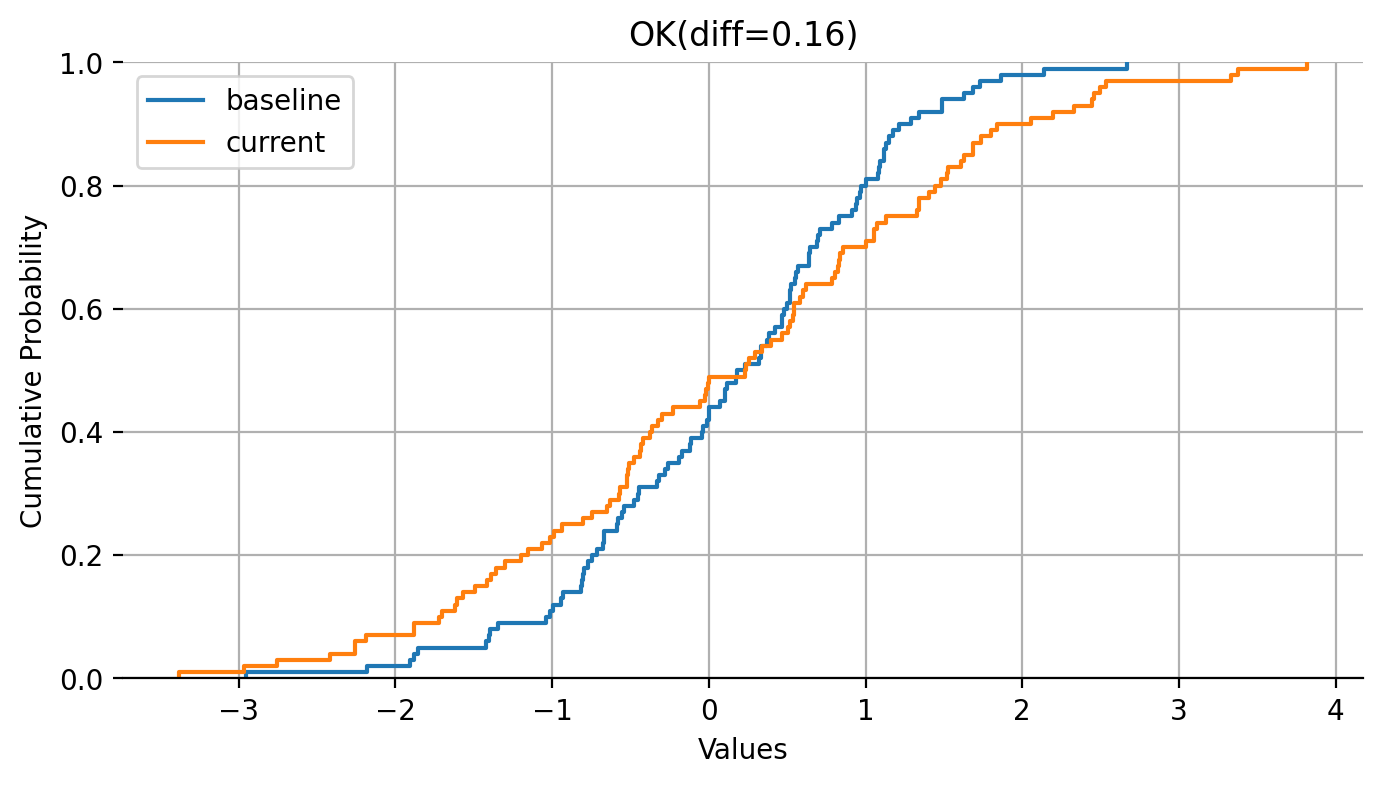

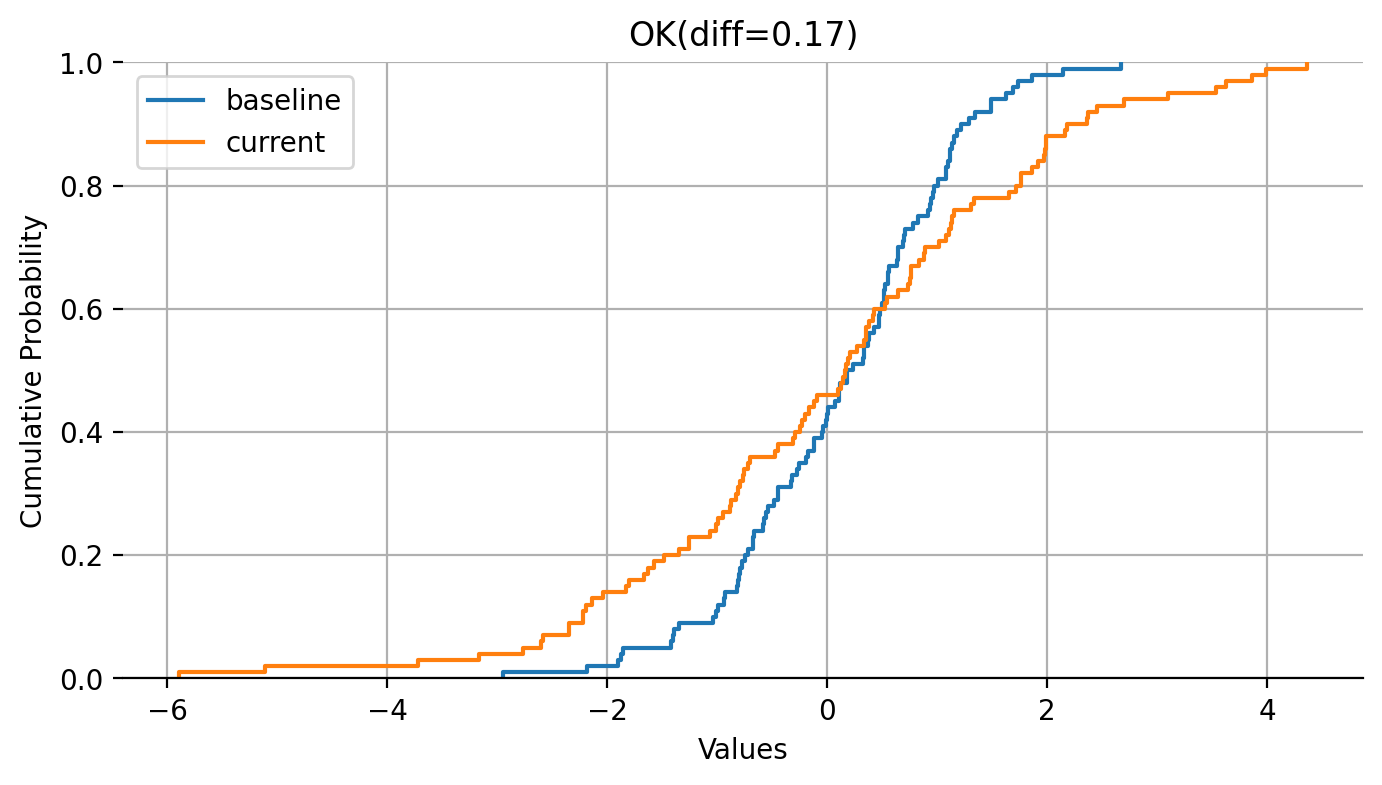

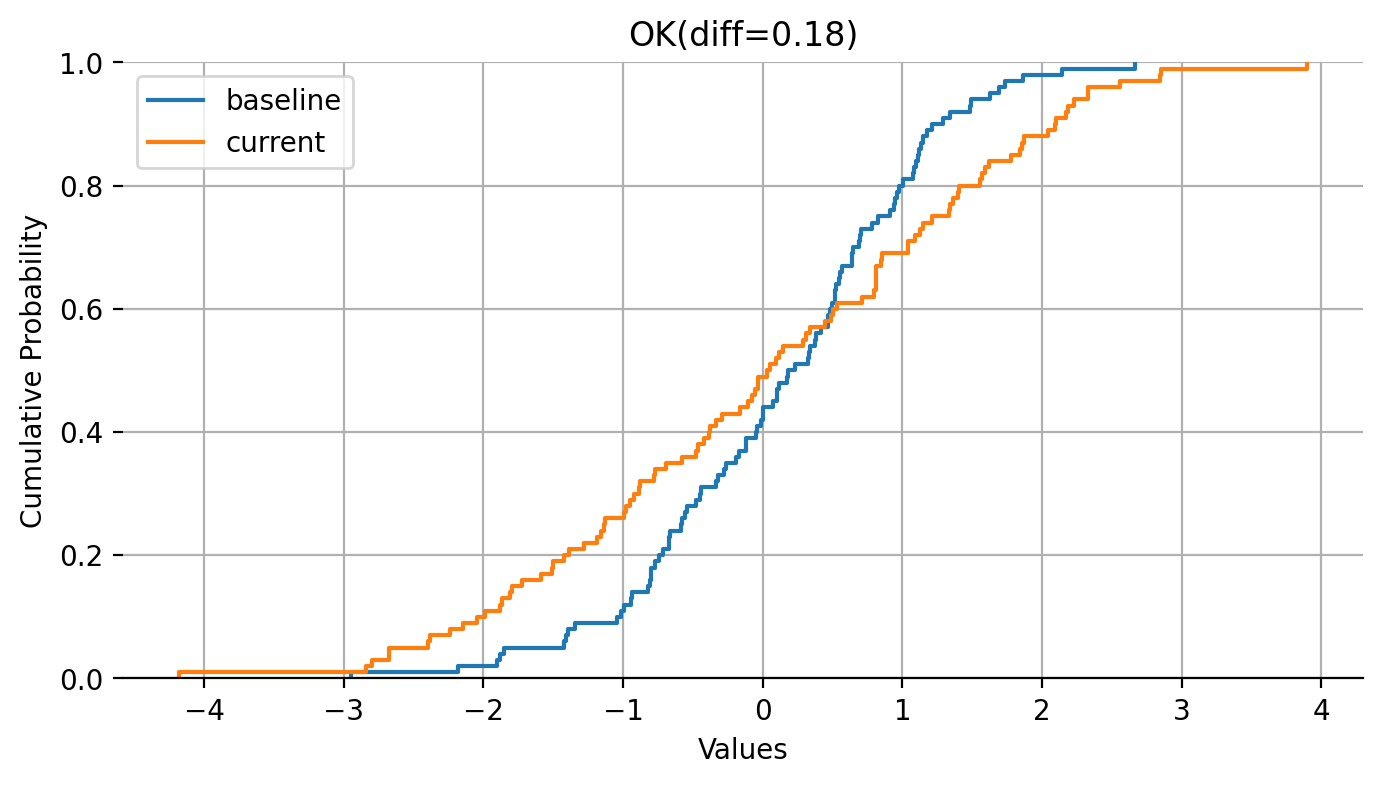

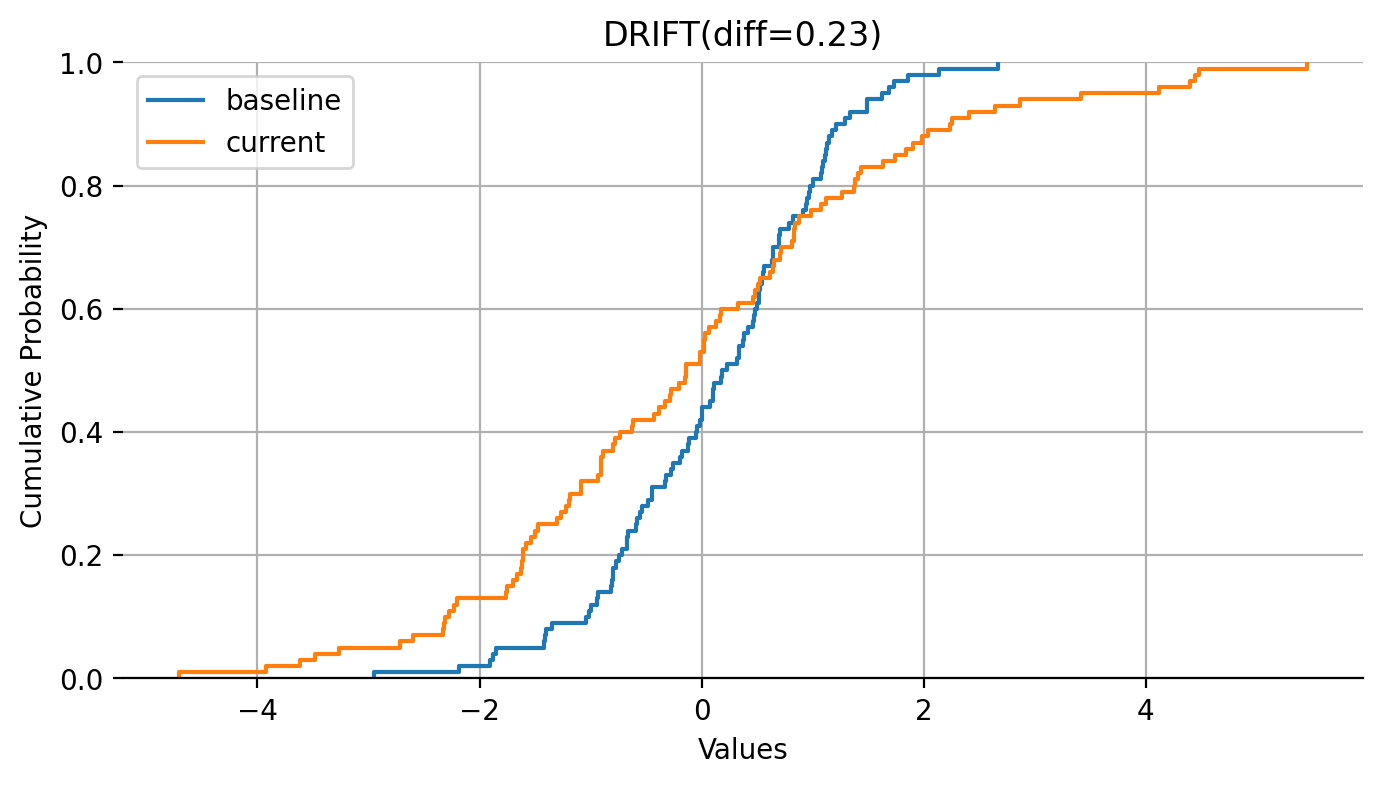

In [20]:
scale = 1.
step = 0.1
samples = 100
bins = samples//10
drift = False

baseline = np.random.normal(scale=scale, size=samples)

while not drift:
  
  scale += step
  current = np.random.normal(scale=scale, size=samples)
  
  ks = scipy.stats.ks_2samp(baseline, current)
  drift = ks.pvalue < .05 
  
  plt.figure(figsize=(8, 4))
  plt.ecdf(baseline, label='baseline')
  plt.ecdf(current, label='current')
  plt.legend()
  plt.ylabel('Cumulative Probability')
  plt.xlabel('Values')
  plt.title(('OK' if not drift else 'DRIFT') + f'(diff={ks.statistic:.2f})')
  plt.grid(True)
  sns.despine(left=True)
  plt.show()


### Population Stability Index

Аббревиатура не самая удачная – [PSI](https://www.nannyml.com/blog/population-stability-index-psi). Не совсем статистический критерий в классическом смысле.

Интерпретируется так:

* PSI <  0.1 – изменений нет;
* PSI >= 0.1 – наблюдаются незначительные изменения;
* PSI >= 0.2 – изменения критичны, нужно заново обучать модель;


In [21]:
def psi(baseline, current):
  edges = np.histogram_bin_edges(
    np.concatenate((baseline, current)),
    bins='doane'
  )

  baseline_bins, _ = np.histogram(baseline, bins=edges)
  current_bins, _ = np.histogram(current, bins=edges)

  baseline_ratio = baseline_bins / np.sum(baseline_bins)
  current_ratio = current_bins / np.sum(current_bins)

  baseline_ratio = np.where(baseline_ratio == 0, 1e-6, baseline_ratio)
  current_ratio = np.where(current_ratio == 0, 1e-6, current_ratio)

  psi_values = (baseline_ratio - current_ratio) * np.log(baseline_ratio / current_ratio)
  psi = np.sum(psi_values)

  return (psi, baseline_ratio, current_ratio)


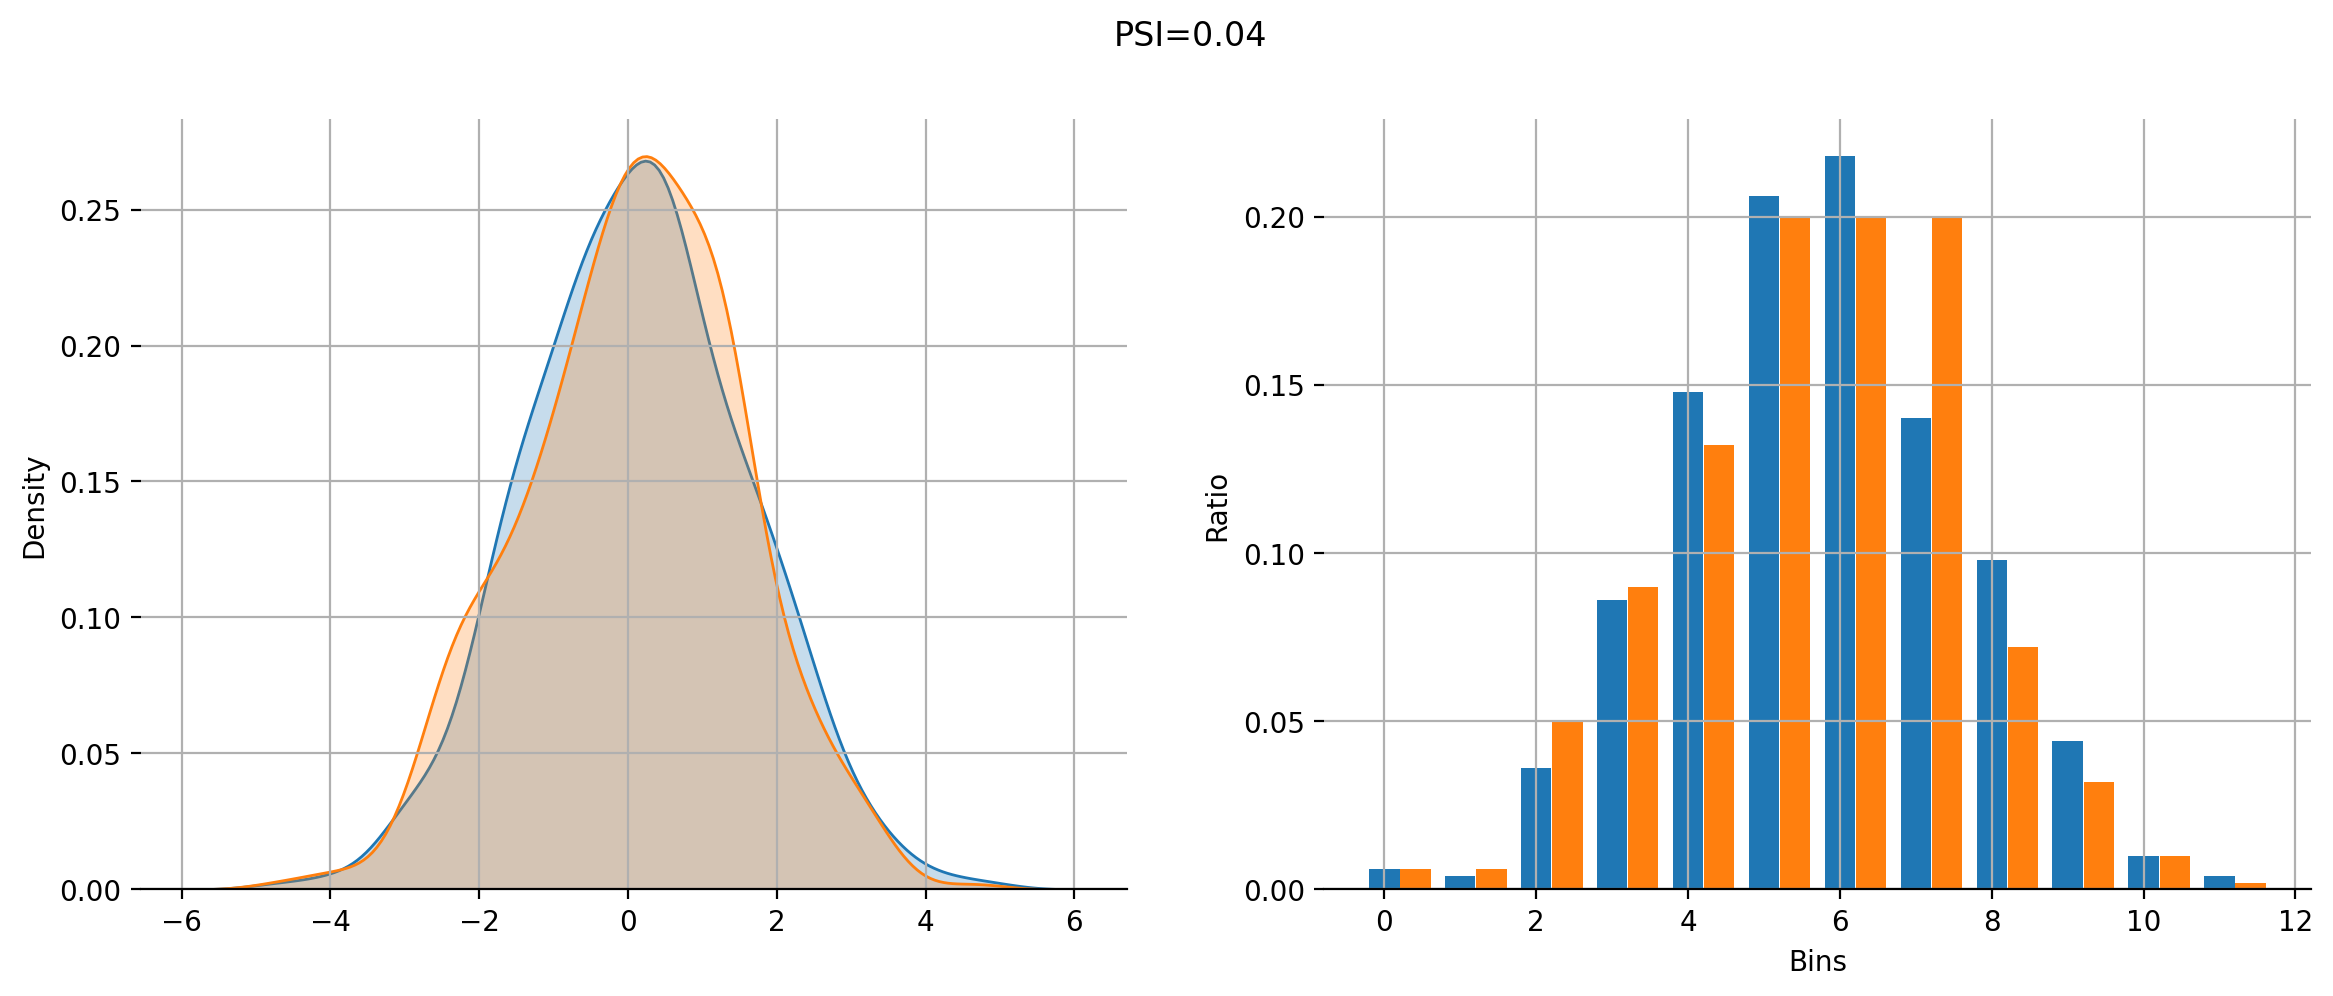

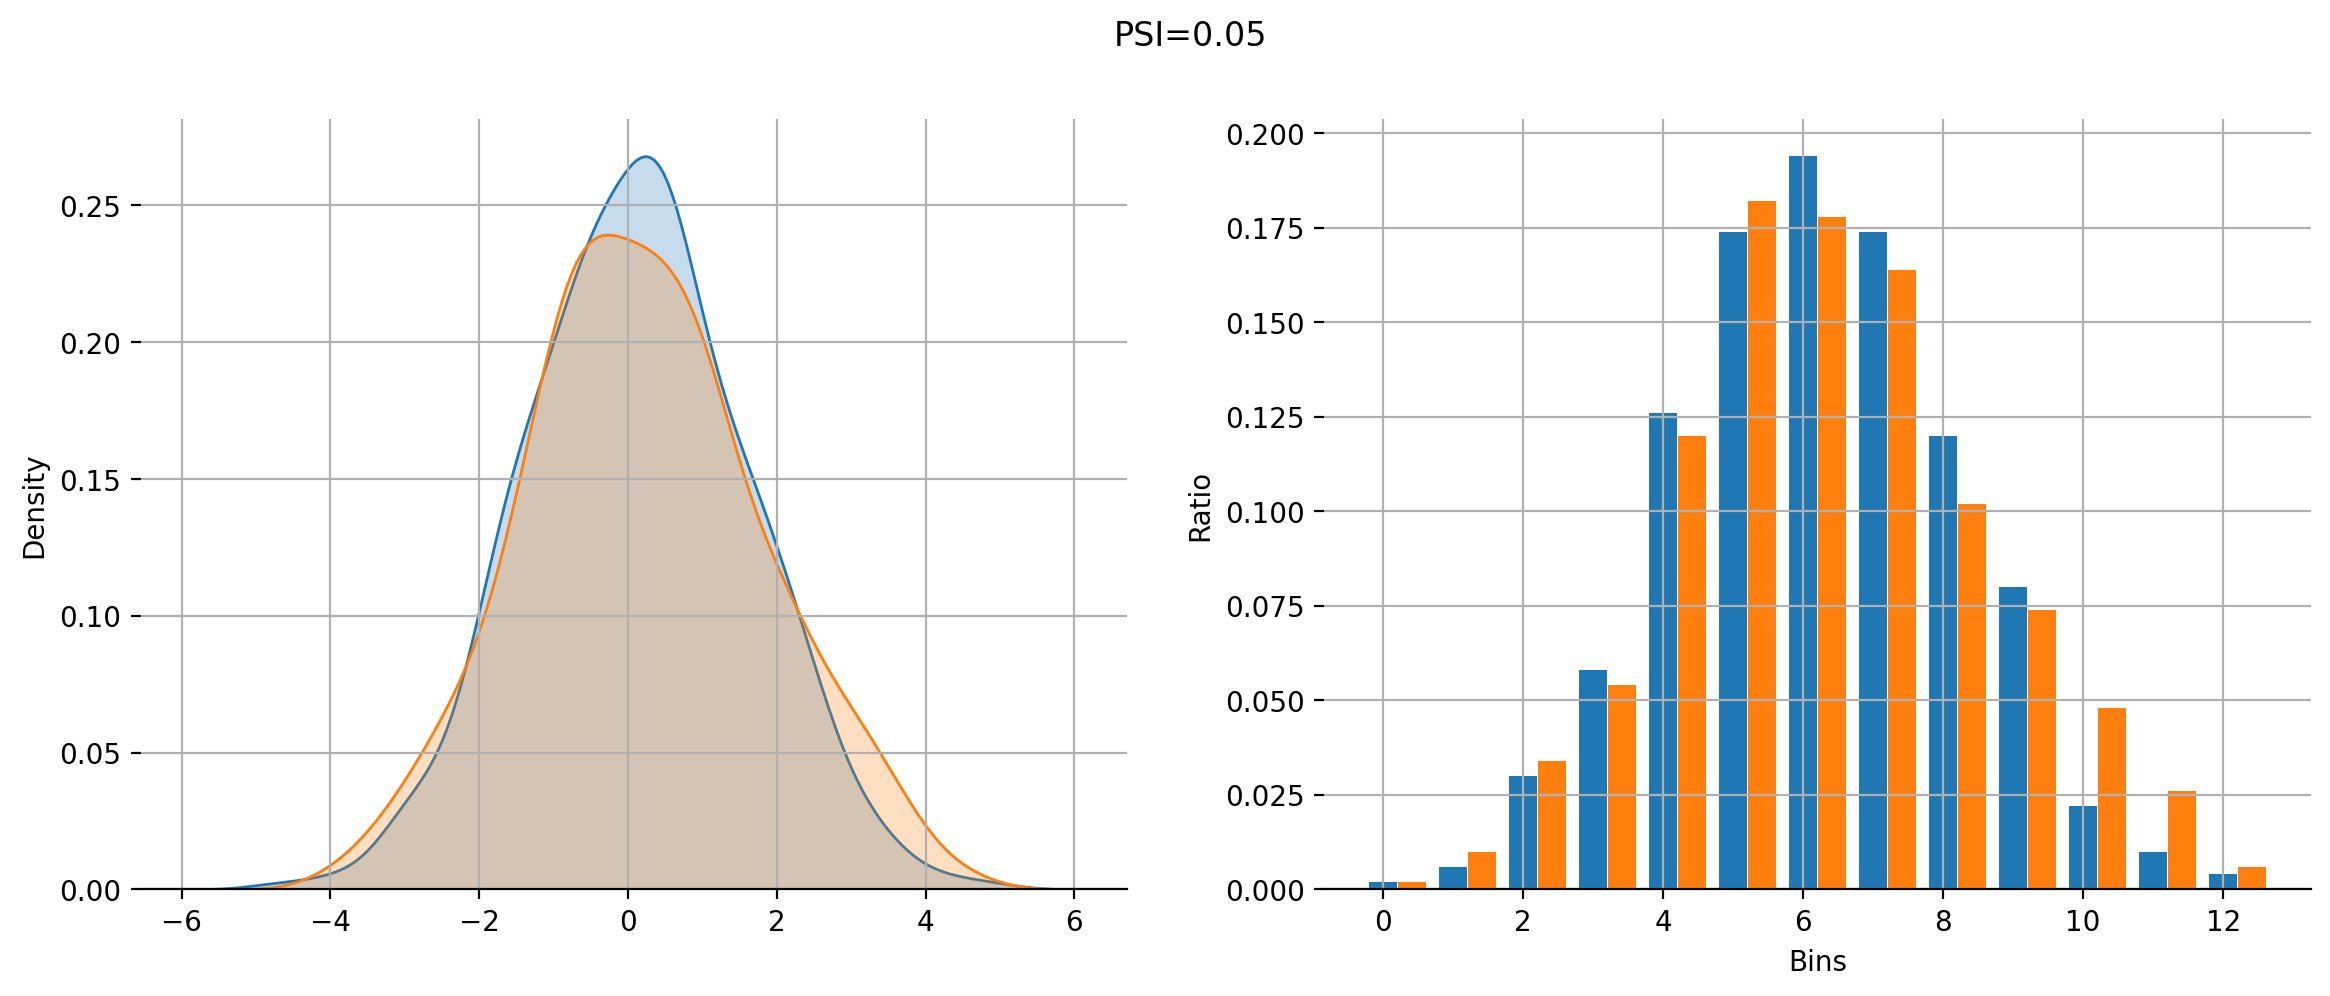

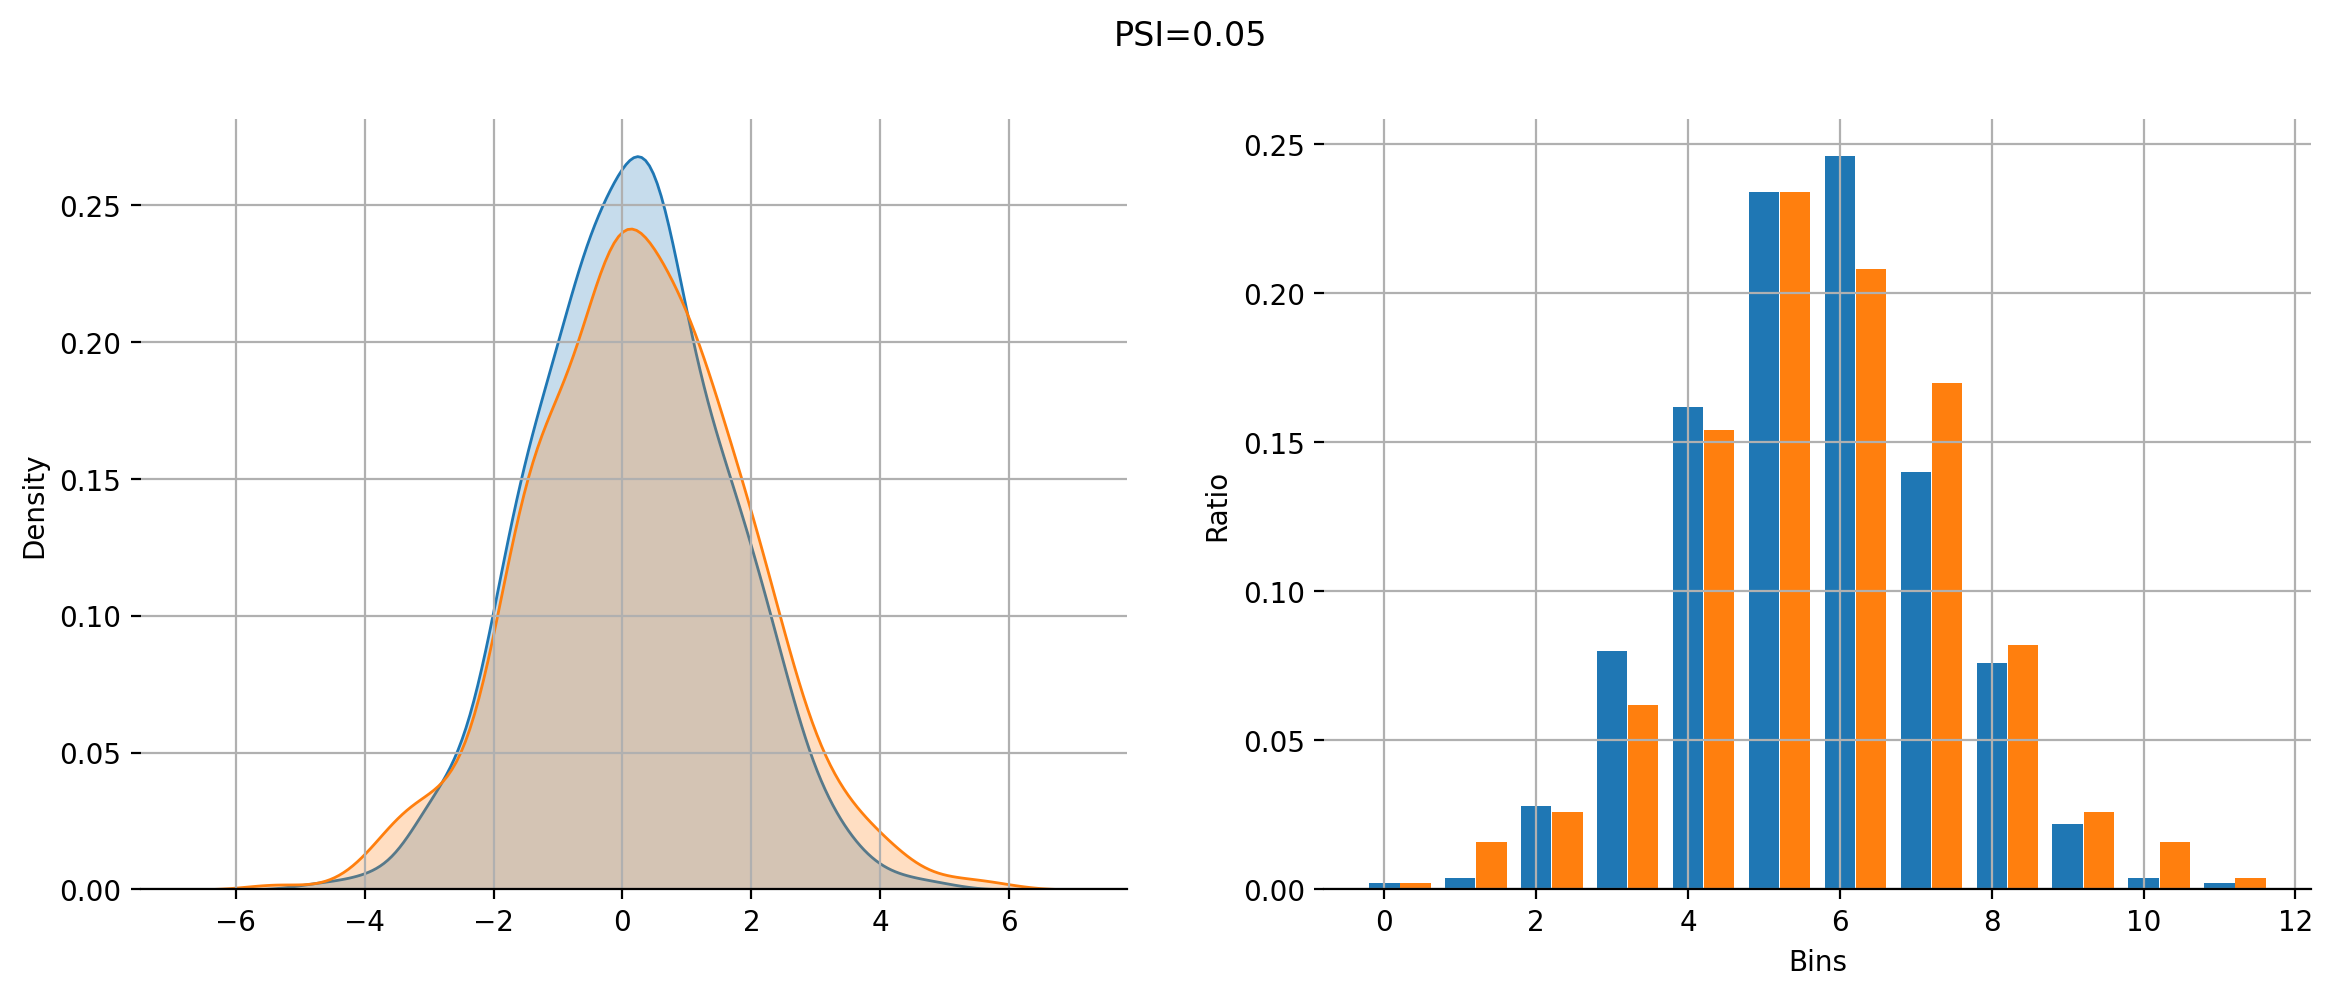

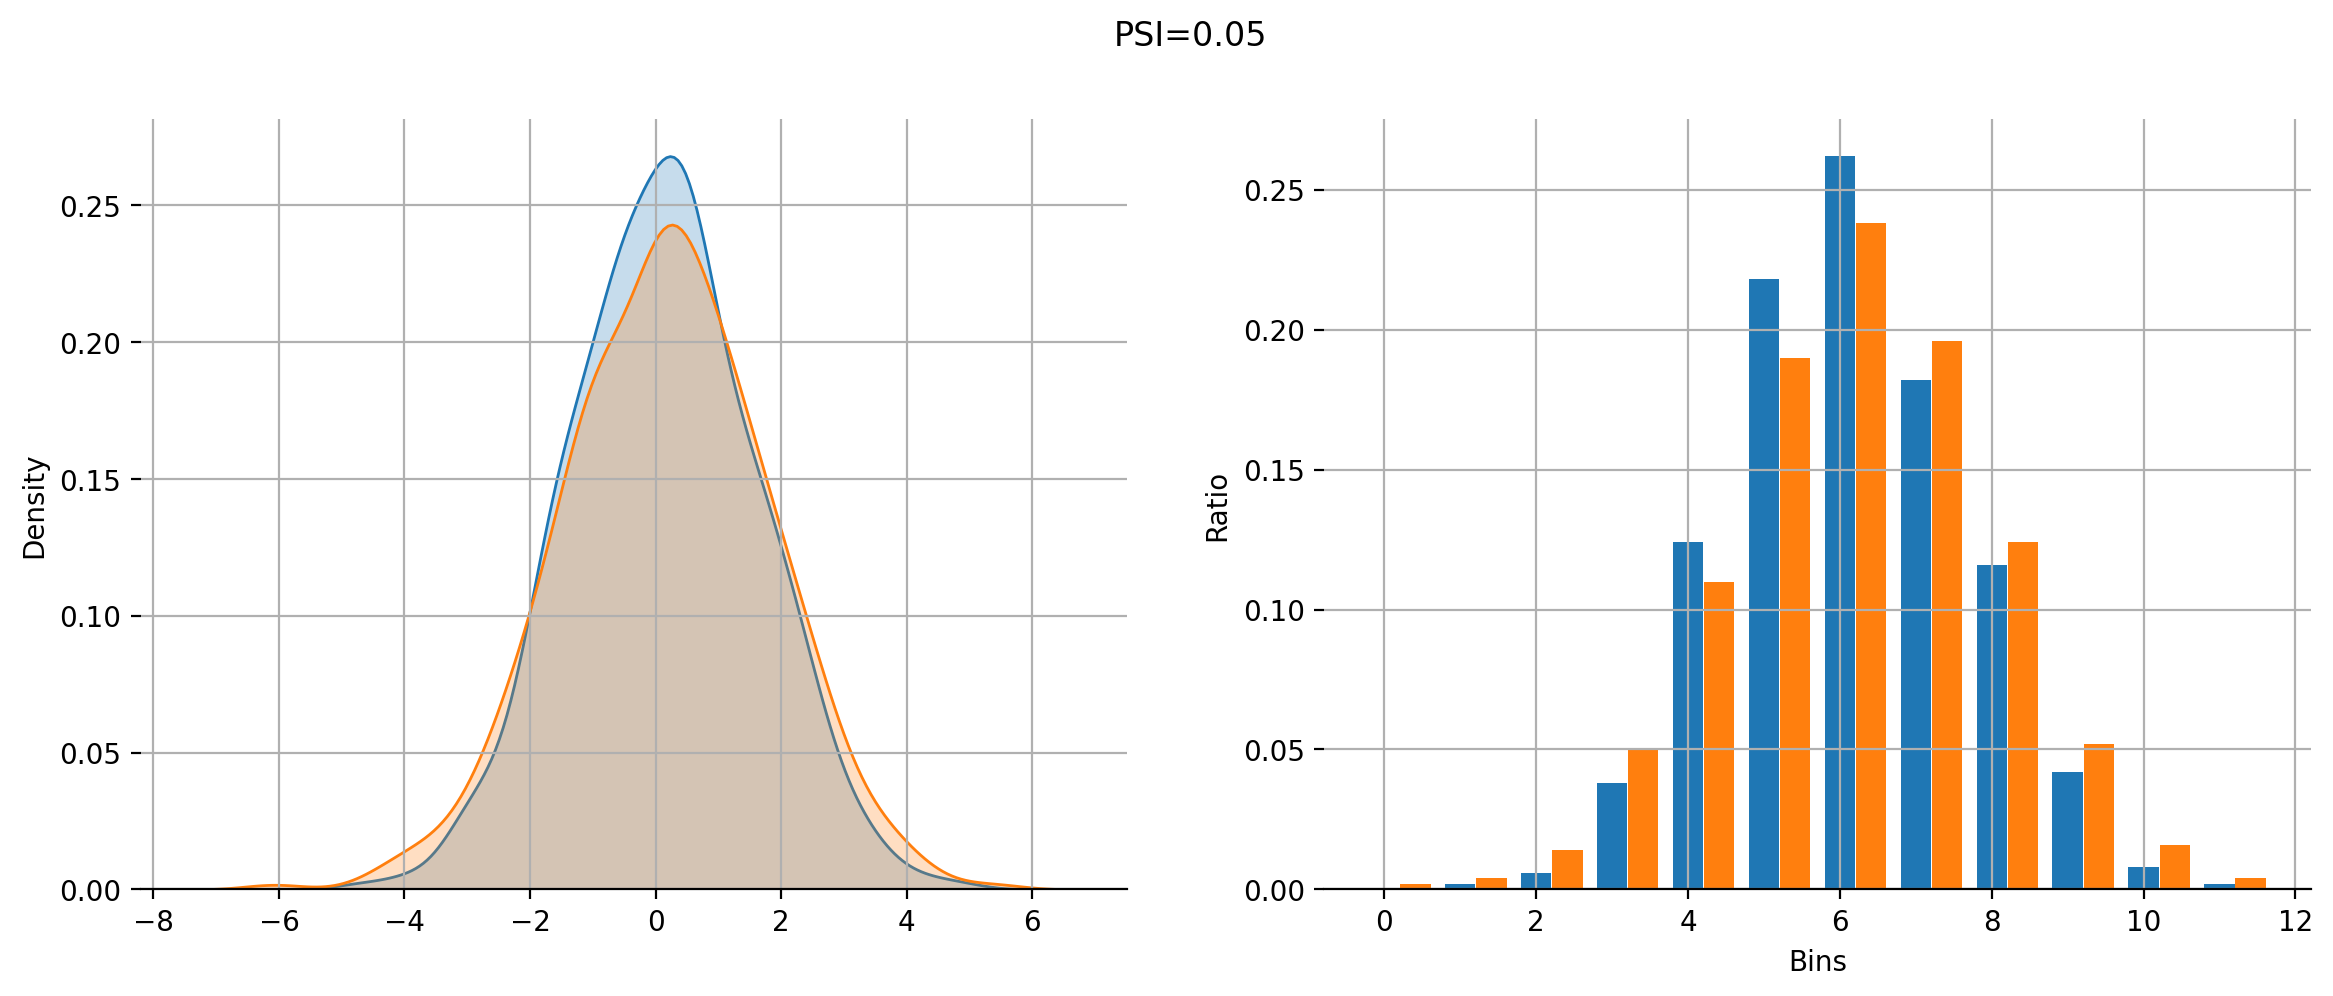

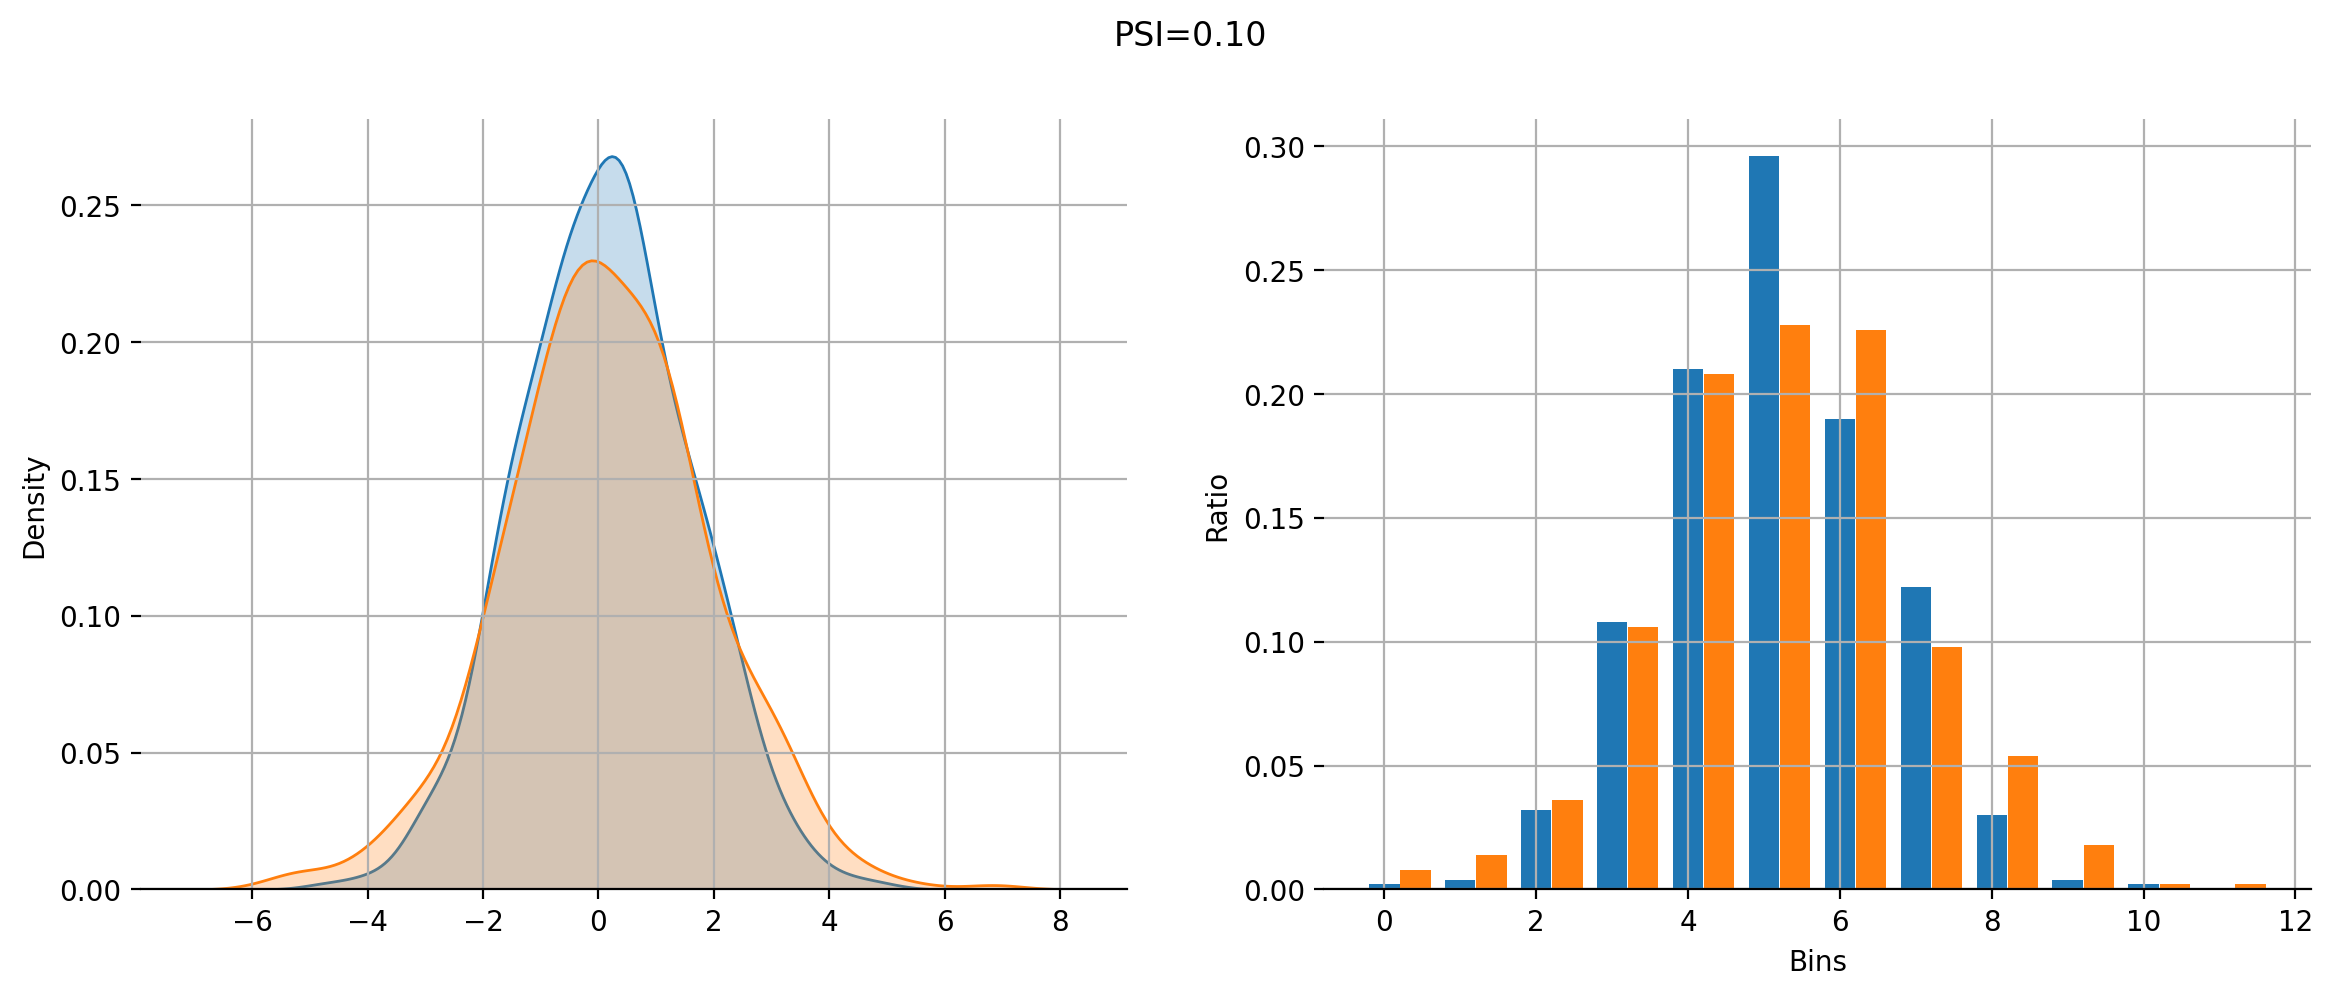

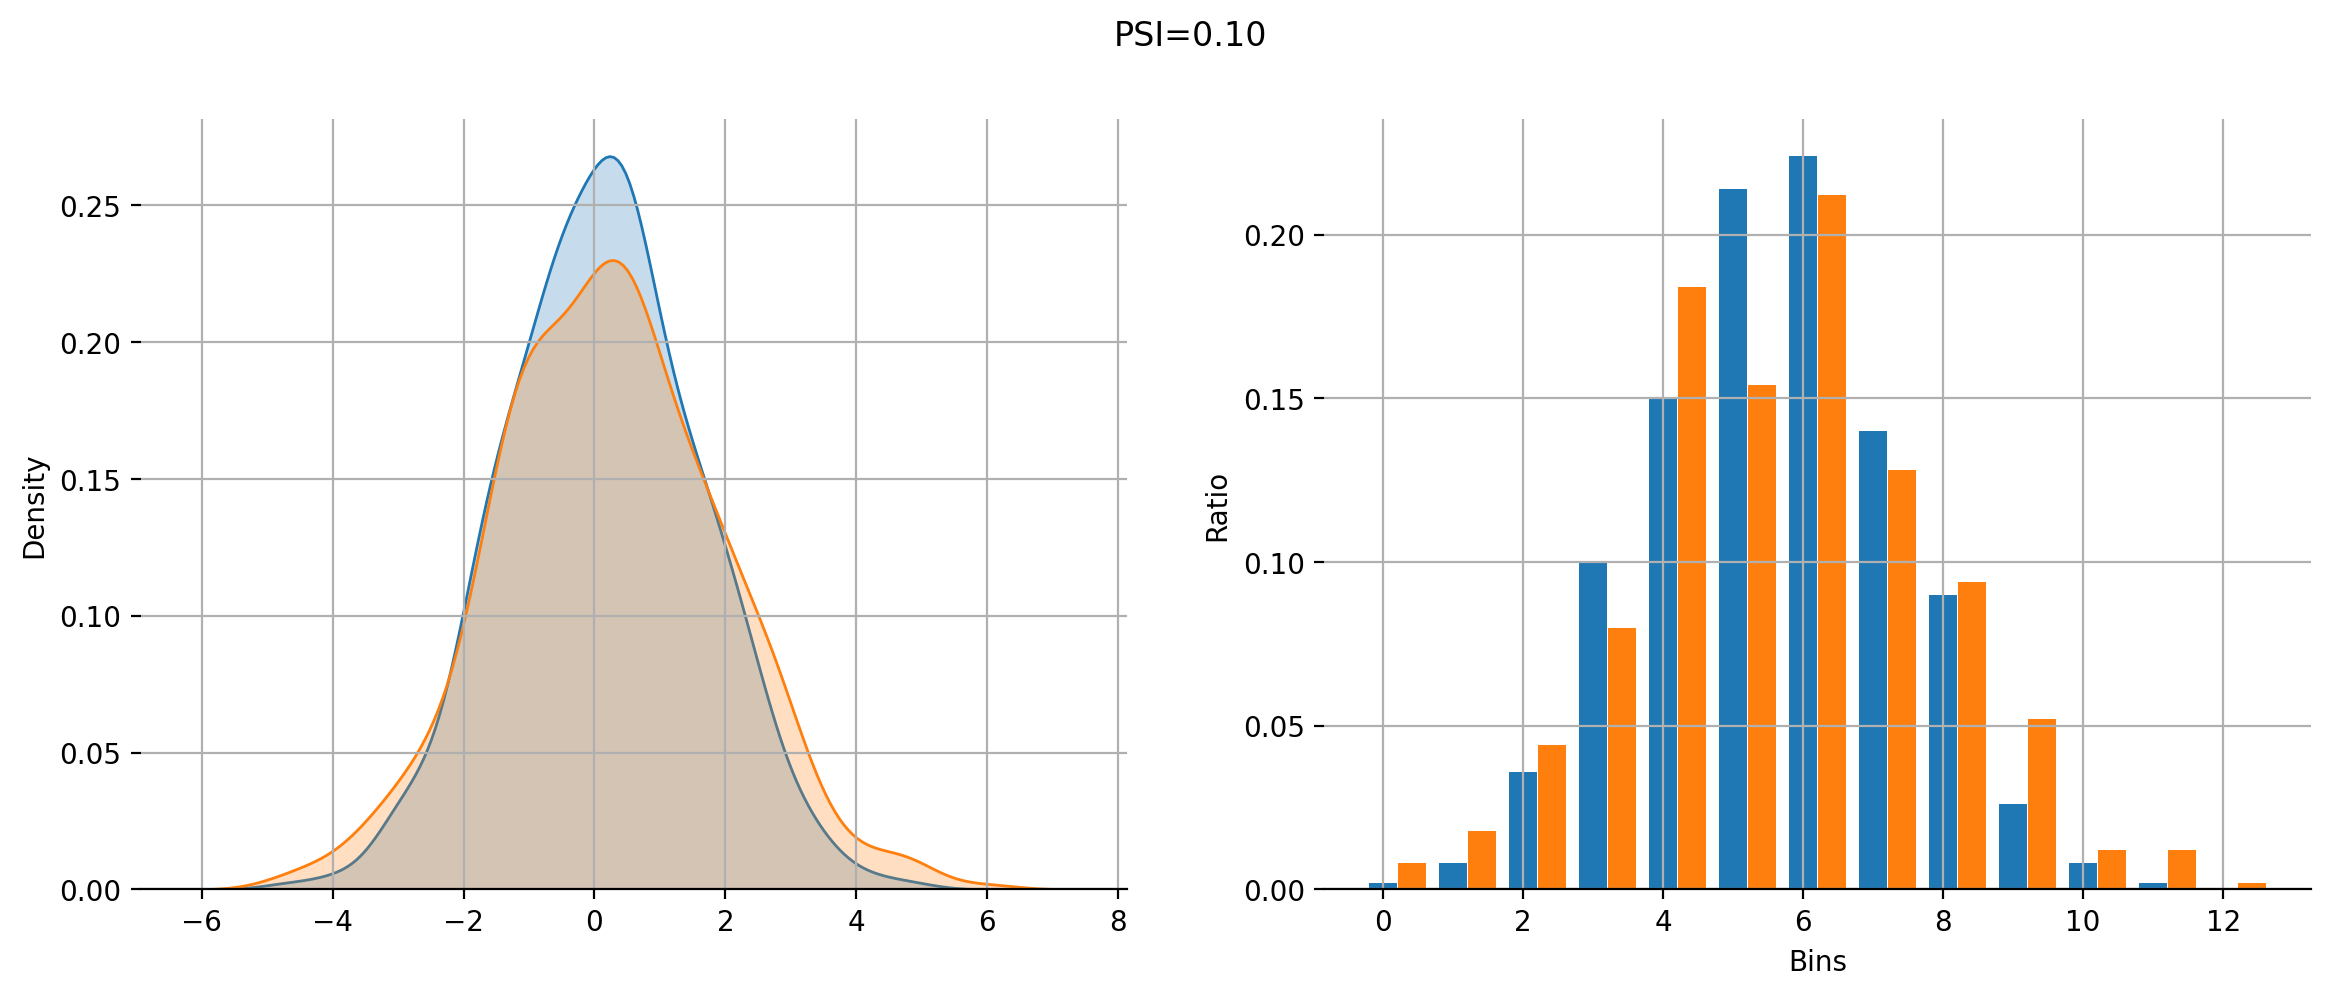

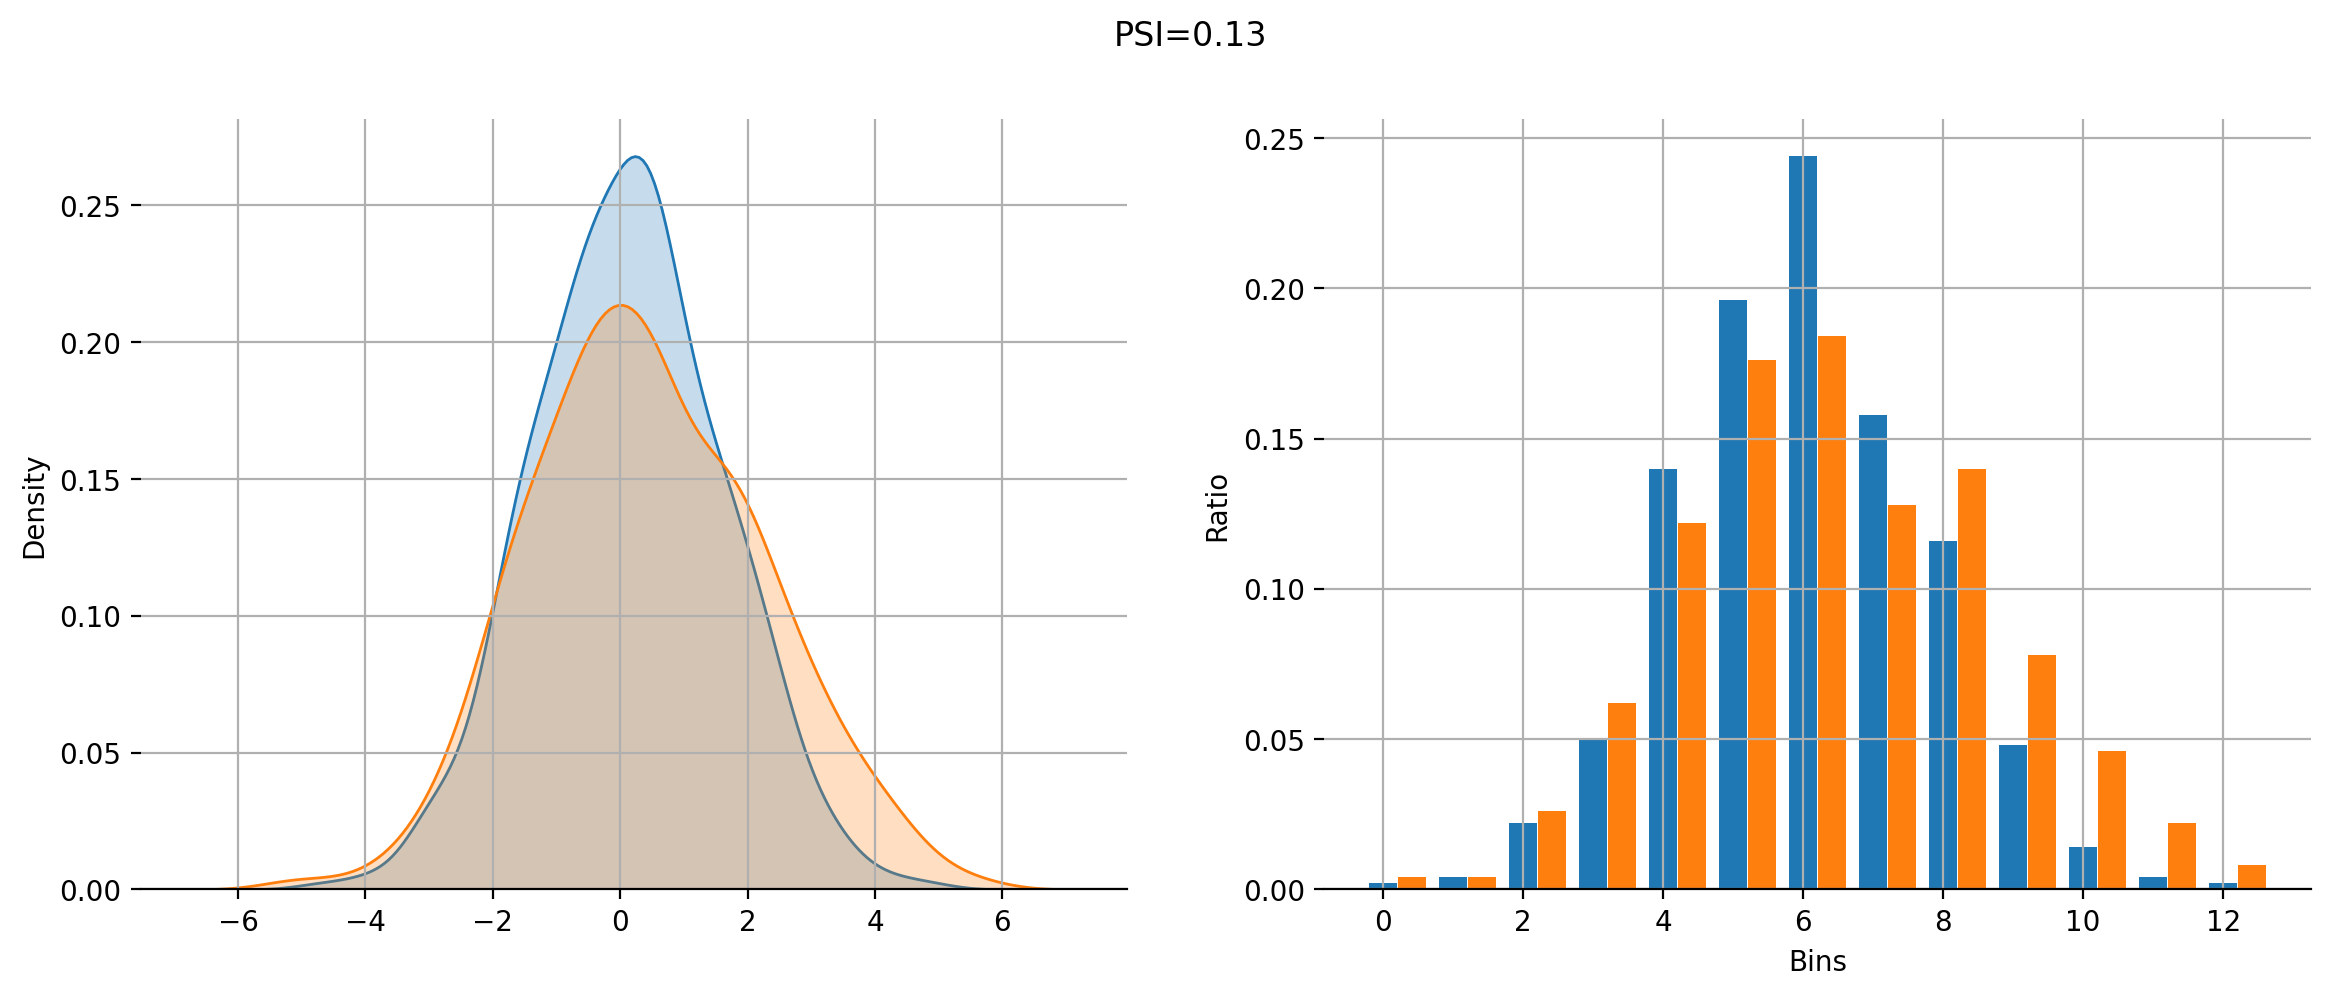

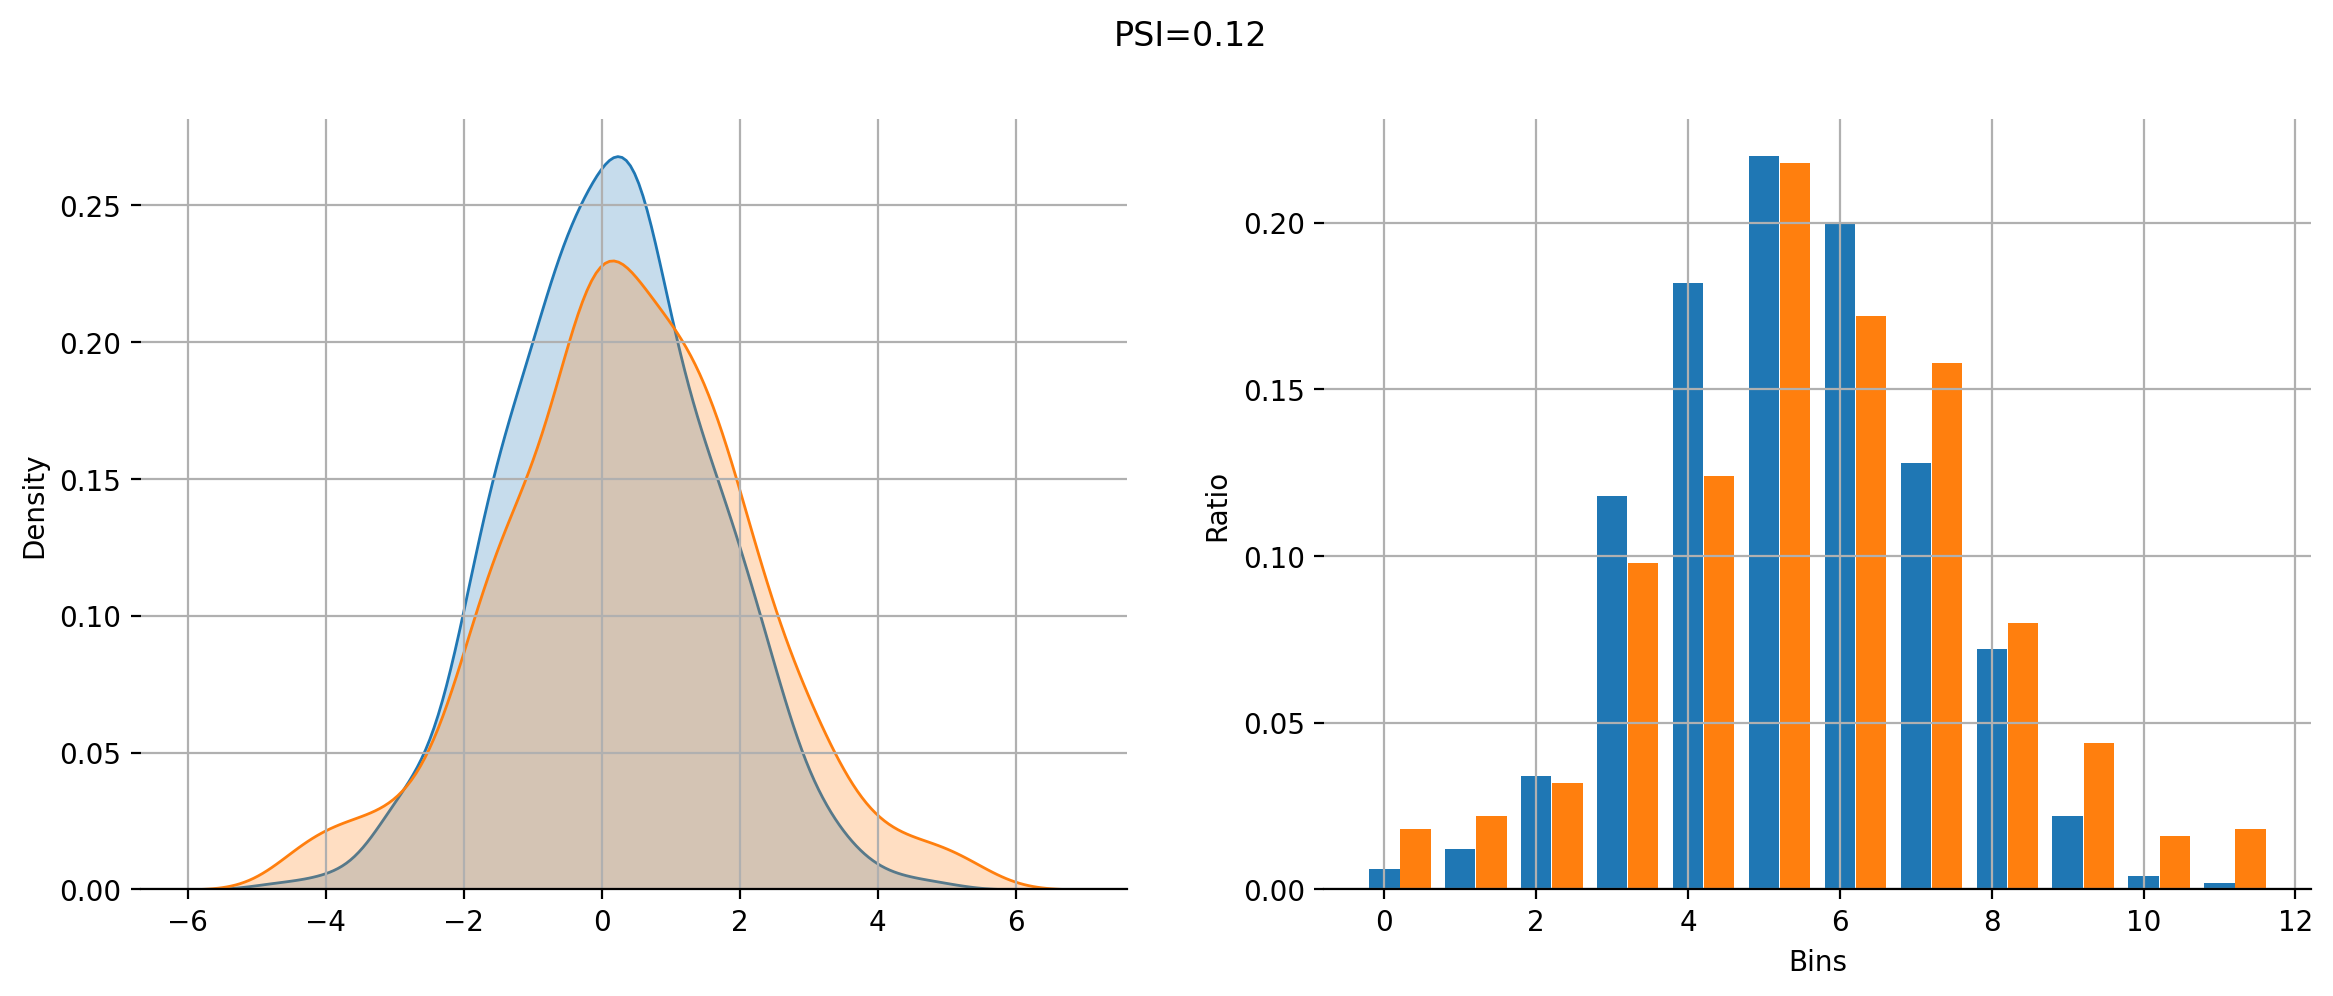

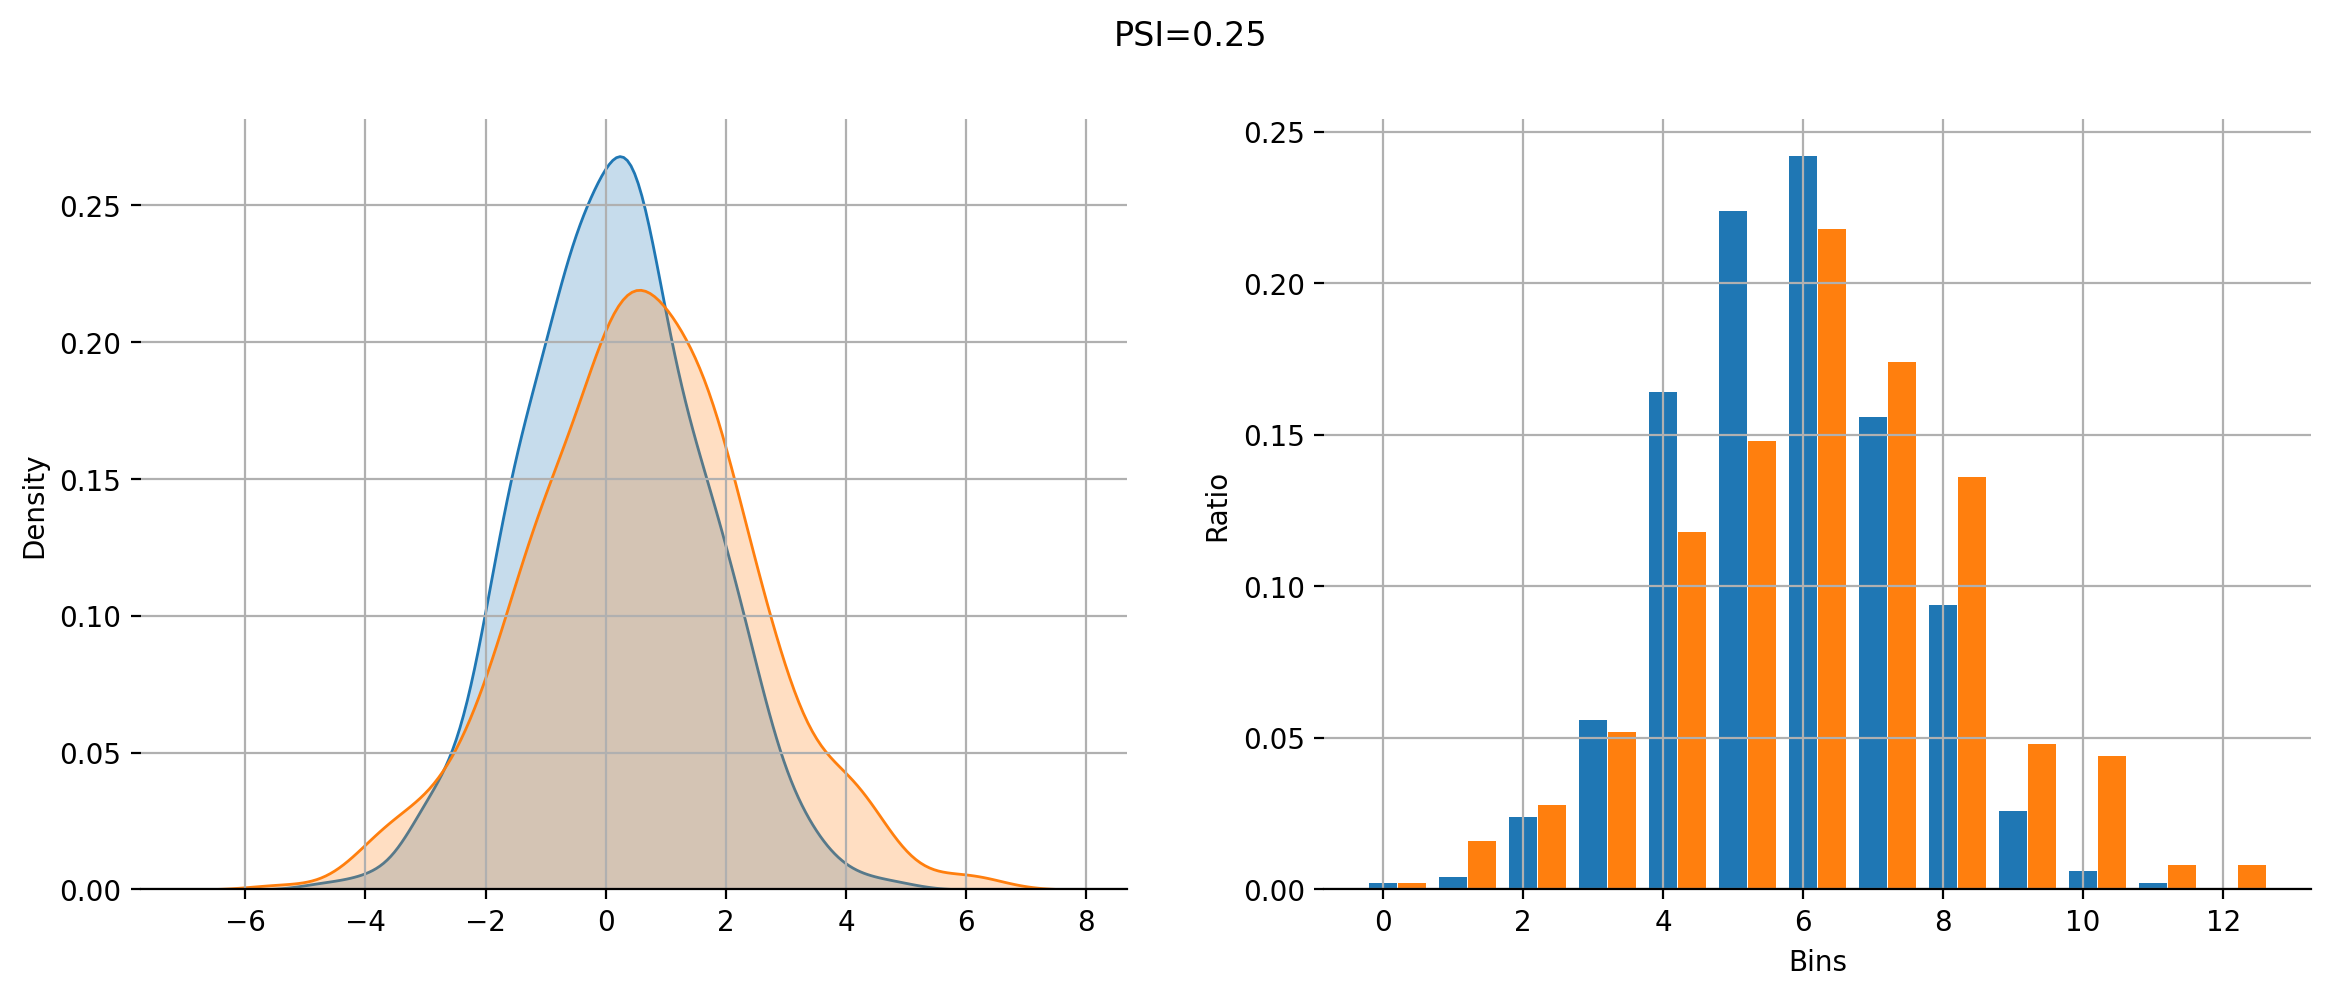

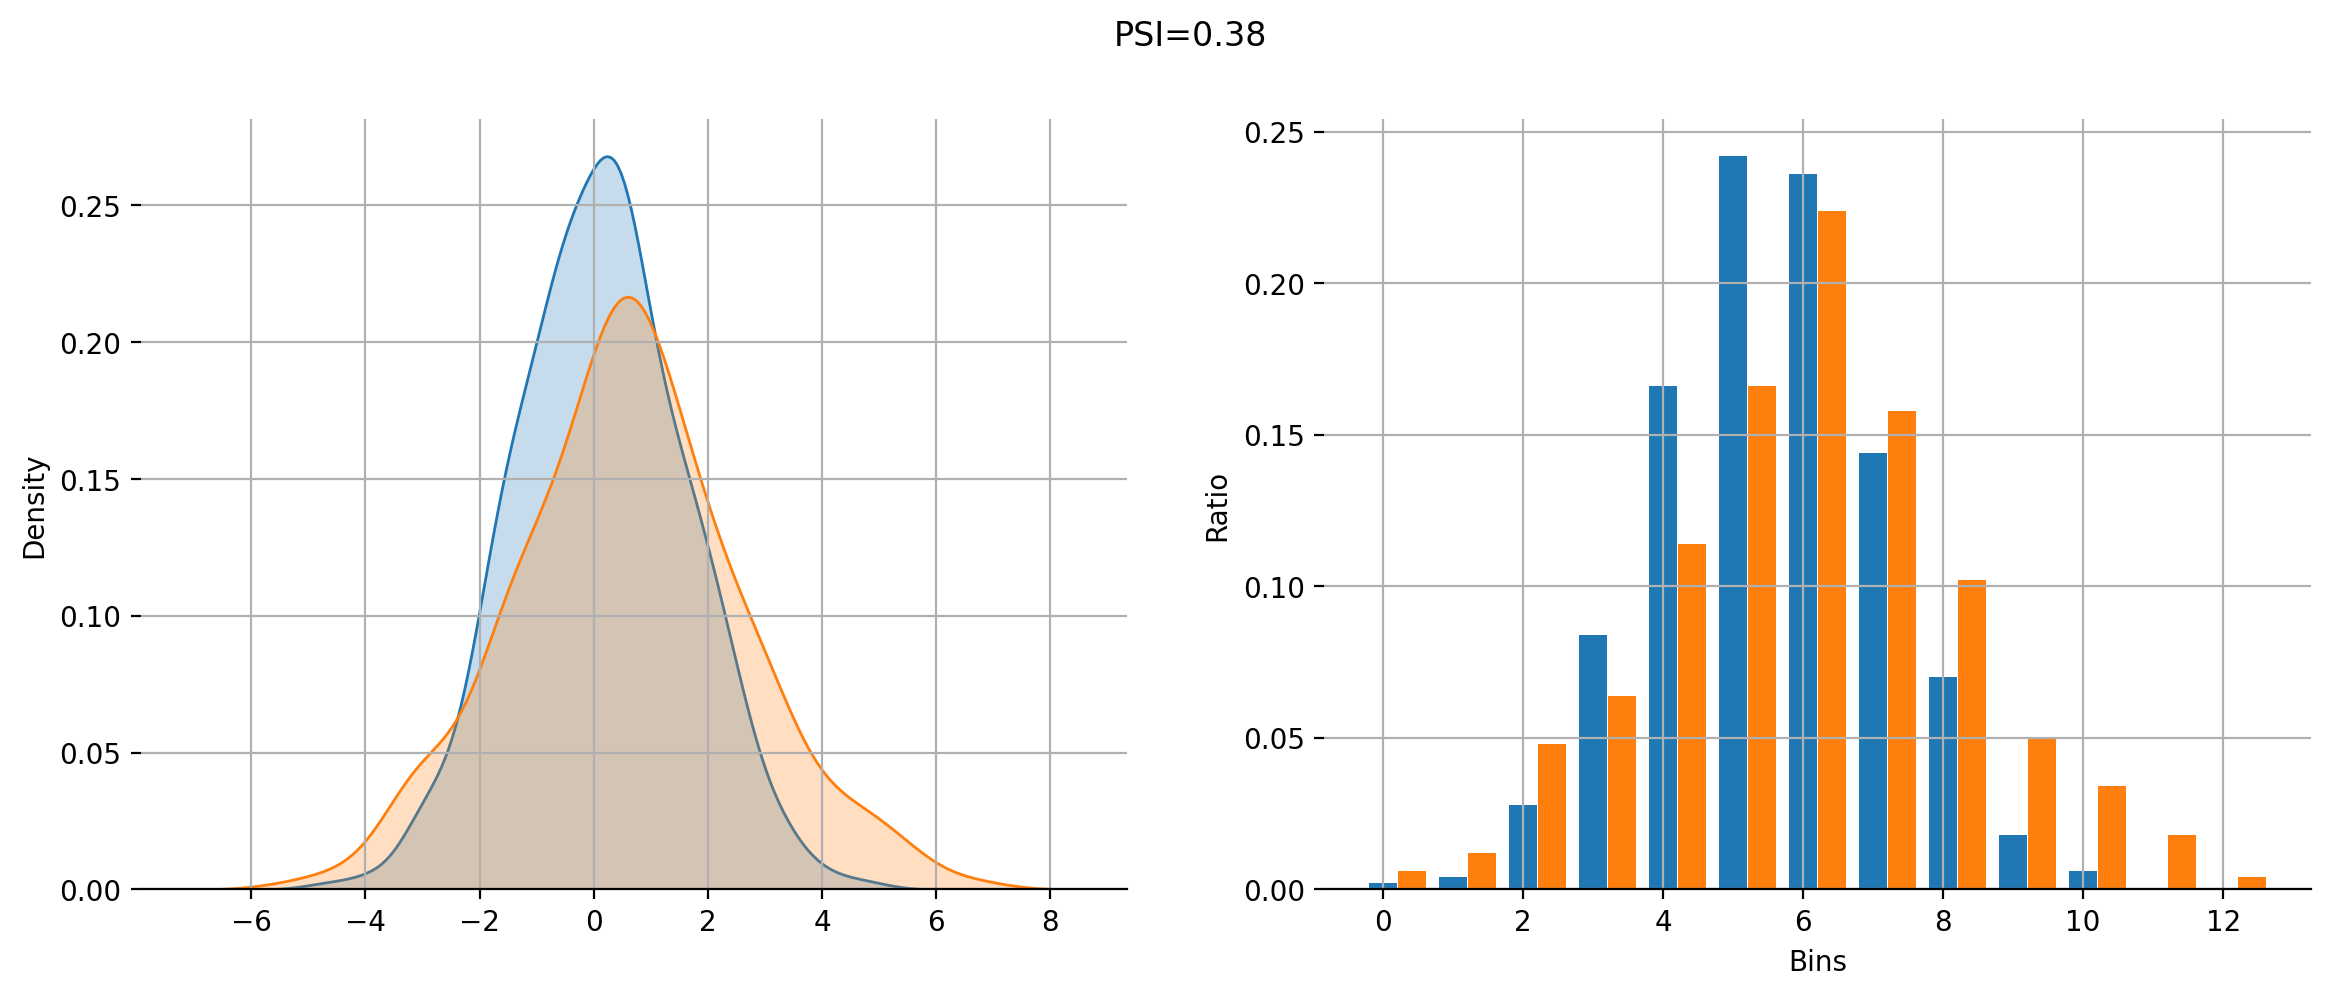

In [22]:
samples = 500
trials = 10
loc, scale = 0., 1.5
step = 0.05

baseline = np.random.normal(loc=loc, scale=scale, size=samples)

for _ in range(10):
  
  loc += step
  scale += step
  current = np.random.normal(loc=loc, scale=scale, size=samples)

  v, baseline_bins, current_bins = psi(baseline, current)

  fig = plt.figure(figsize=(14, 5))
  ax = fig.subplots(1, 2)

  sns.kdeplot(baseline, fill=True, ax=ax[0], label='baseline')
  sns.kdeplot(current, fill=True, ax=ax[0], label='current')
  ax[0].grid(True)

  x = np.arange(len(baseline_bins))
  w = .4

  ax[1].bar(x, baseline_bins, width=w)
  ax[1].bar(x+w+0.01, current_bins, width=w)
  ax[1].grid(True)
  ax[1].set_xlabel('Bins')
  ax[1].set_ylabel('Ratio')


  fig.suptitle(f'PSI={v:.2f}')
  sns.despine(left=True)
  plt.show()